In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sm
# import Bio
# from sklearn.preprocessing import PolynomialFeatures
# #from scipy import interpolate
#Ю from scipy.optimize import fsolve
import scipy.io
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from shapely.geometry import  LineString
import random as rn
import seaborn as sns

In [2]:
class TriMatrix():
    '''
    большой массив с начальными данными по всем трём периодам
    '''
    def __init__(self, FilePath):
        with open(FilePath) as genoms_file:
            genoms = genoms_file.read()
        NASlist = []
        NamesAndSequence =genoms.split('>')
        for NameAndSeq in NamesAndSequence[1:]:
            NASlist.append(NameAndSeq.split('\n')[:-1])
        NASdict = {}
        for i in NASlist:
            if list(i[-1]) != list(i[0]):
                NASdict[i[0]] = list(i[-1])
        # датафрейм по 3 периодам сразу        
        self.df = pd.DataFrame.from_dict(NASdict, orient='index', 
                                         columns=range(1, len(NASlist[0][-1]) + 1))  
        self.origin = self.df.copy()
        
    def Separation(self):
        """
        Разделяет на 3 отдельных объекта
        """
        dict1 = {}
        dict2 = {}
        dict3 = {}
        for name in self.df.index:
            if 'cov1' in name:
                dict1[name] = self.df.loc[name]
            elif 'cov2' in name:
                dict2[name] = self.df.loc[name]
            elif 'cov3' in name:
                dict3[name] = self.df.loc[name]
        df1 = pd.DataFrame.from_dict(dict1, orient='index')
        df2 = pd.DataFrame.from_dict(dict2, orient='index')
        df3 = pd.DataFrame.from_dict(dict3, orient='index')
        m1 = Matrix()
        m1.df = df1
        m2 = Matrix()
        m2.df = df2
        m3 = Matrix()
        m3.df = df3
        return m1, m2, m3
        
class Matrix():
    def ColumnsCleaning(self, SiteGapsThreshold, SiteMonomorphThreshold):
        DropList = []
        '''
        Удаляет столбец если в нём слишком много пропусков
        '''
        for i in self.df.columns:
            if '-' in self.df.loc[:, i].value_counts():
                if self.df.loc[:, i].value_counts()['-']/self.df.shape[0]>=SiteGapsThreshold:
                    DropList.append(i)
        '''
        Удаляет столбец если в нём меньше чем определённое количество элементов,
        отличных от консенсуса
        '''
        SiteMonomorphThreshold = 1-SiteMonomorphThreshold
        for i in self.df.columns:
            if len(self.df.loc[:,i].value_counts())>=2:
                if self.df.loc[:,i].value_counts().max()/self.df.shape[0]<=SiteMonomorphThreshold:
                    DropList.append(i)
            elif len(self.df.loc[:,i].value_counts())==1:
                DropList.append(i)
        DropList = list(set(DropList))
        self.df.drop(DropList, inplace=True, axis=1)
        
    def IndexCleaning(self, SeqGapsThreshold):
        """
        Удаляет последовательность если в ней слишком много пропусков
        """
        DropList = []
        for i in self.df.index:
            if '-' in self.df.loc[i, :].value_counts():
                if self.df.loc[i, :].value_counts()['-']/self.df.shape[1]>=SeqGapsThreshold:
                    DropList.append(i)
#         print(DropList)
        self.df.drop(DropList, inplace=True)

    def Binarization(self):
        """
        Преобразует в двоичный вид. 0 - более распространённый вариант. 1 - мутации
        """
        for i in self.df.columns:
            self.df.loc[self.df[i] == self.df.loc[:,i].value_counts().idxmax(), i] = 0
            self.df.loc[self.df[i] != self.df.loc[:,i].value_counts().idxmax(), i] = 1

In [3]:
def poly(x,y):
    poly = PolynomialFeatures(degree=4, include_bias=False)
    x=x
    y=y
    poly_features = poly.fit_transform(x.reshape(-1, 1))
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, y)
    y_predicted = poly_reg_model.predict(poly_features)
    return y_predicted

In [4]:
class Graphs():  
    def __init__(self, m1, m2, m3, C=0, SearchIntersection=False):
        self.C=C
        self.df1 = m1.df
        self.df2 = m2.df
        self.df3 = m3.df
#         смотрим пересечения по периодам
        self.set1 = set(self.df1.columns)
        self.set2 = set(self.df2.columns)
        self.set3 = set(self.df3.columns)
        self.set12 = self.set1 & self.set2
        self.set13 = self.set1 & self.set3
        self.set23 = self.set2 & self.set3
        self.set123 = self.set1 & self.set2 & self.set3
        
        '''
        Тут, возможно, лучше заменить на то же что во втором подобном классе, 
        а то здесь это ужс какой-то
        '''
        CountDict1 = {}
        for name, values in self.df1.items():
            if len(self.df1[self.df1[name]==1]) != 0:
                CountDict1[name] = (len(self.df1[self.df1[name]==1]))/len(self.df1)
            else:
                CountDict1[name] = 0

        CountDict2 = {}
        for name, values in self.df2.items():
            if len(self.df2[self.df2[name] == 1]) != 0:
                CountDict2[name] = (len(self.df2[self.df2[name] == 1]))/len(self.df2)
            else:
                CountDict1[name] = 0
                
        CountDict3 = {}
        for name, values in self.df3.items():
            if len(self.df3[self.df3[name] == 1]) != 0:
                CountDict3[name] = (len(self.df3[self.df3[name] == 1]))/len(self.df3)
            else:
                CountDict1[name] = 0
        
        
        
        self.Dict123 = {1:CountDict1, 2:CountDict2, 3:CountDict3}

        self.Frame123 = pd.DataFrame(self.Dict123)#.dropna(axis='index')
        self.Frame123 = self.Frame123.loc[list(self.set123)]
        self.Frame123.loc[:,'mean'] = self.Frame123.mean(axis=1)
        
        
        self.new_ids = list(self.Frame123.sort_values('mean', axis=0, ascending=True).index)
        self.SortFrame = self.Frame123.sort_values('mean', axis=0, ascending=True)
        self.logFrame = np.log((1-self.SortFrame)/self.SortFrame)
        
        self.SearchIntersection = SearchIntersection
        
        self.x=np.arange(1,len(self.new_ids)+1)
        self.y=(self.logFrame.loc[:,1].to_numpy())
        self.y2=(self.logFrame.loc[:,2].to_numpy())
        self.y3=(self.logFrame.loc[:,3].to_numpy())
        if self.SearchIntersection:    
            line_1 = LineString(np.column_stack((self.x, poly(self.x,self.y))))
            line_2 = LineString(np.column_stack((self.x, poly(self.x,self.y2))))
            line_3 = LineString(np.column_stack((self.x, poly(self.x,self.y3))))
            self.intersection12 = line_1.intersection(line_2)
            self.intersection13 = line_1.intersection(line_3)
            self.intersection32 = line_3.intersection(line_2)
            
    def PrintL(self):
        '''
        Показывает сколько осталось сайтов и сколько пересечений по 
        оставшимся сайтам между периодами
        '''
        texts = ['L1', 'L2', 'L3', 'L12', 'L13', 'L23', 'L123']
        sets = [self.set1, self.set2, self.set3, self.set12, self.set13, self.set23, self.set123]
        for i in range(7):
            print(texts[i],'=',str(len(sets[i])))
            


    def sMeasureLine(self, Mean=False, 
                     axis = 'unvalueAxis'):
        """
        строит график зависимости beta*s от сайтов
        """
        
        plt.figure(figsize=(6,3), dpi = 300)
        plt.xlabel('$m_i$')
        plt.ylabel('$\\beta(t) \\cdot s$')
#         plt.title(f'$f_0={self.f0}, s_0={self.s0}$')
        
        if axis == 'valueAxis':    
            plt.plot([f"{idx}" for idx in self.new_ids], 
                     (self.logFrame.loc[:,1].to_numpy()-self.C),
                     'r.-',label='1')
            plt.plot([f"{idx}" for idx in self.new_ids], 
                     (self.logFrame.loc[:,2].to_numpy()-self.C),
                     'g.-',label='2')
            plt.plot([f"{idx}" for idx in self.new_ids], 
                     (self.logFrame.loc[:,3].to_numpy()-self.C),
                     'k.-',label='3')
            if Mean:
                plt.plot([f"{idx}" for idx in self.new_ids], 
                         (self.logFrame.loc[:,'mean'].to_numpy()-self.C),
                         '.--',label='mean')
            
        elif axis =='unvalueAxis':
            for n in range(1,len(self.mat['Data'][0][0][0])+1):
                plt.plot(self.x, self.yDict[f'y_{n}']-self.C,'.-',
                         label=f't={self.mat["tsecs"][0][n-1]}',color=f'C{n-1}')
            if Mean:
                plt.plot(self.x,(self.logFrame.loc[:,'mean'].to_numpy()-self.C),
                         '.--',label='mean', color='k')
         
        plt.legend()
#         if self.SearchIntersection:
#             plt.plot(self.x0,0,'ok')
#             ax = plt.gca()
#             ax.axhline(y=0, color='k',ls=':')   
    
    def PolyS(self):
        plt.figure(figsize=(6,3), dpi = 200)
        plt.xlabel('$m_i$')
        plt.ylabel('$\\beta(t) \\cdot s_i$')
        for n in range(1,len(self.mat['Data'][0][0][0])+1):
            plt.plot(self.x, self.yDict[f'y_{n}'],'.-',alpha=0.3, 
                     color=f'C{n-1}',label=f't={self.mat["tsecs"][0][n-1]}')
            plt.plot(self.x, poly(self.x,self.yDict[f'y_{n}']), 
                     color=f'C{n-1}')
        plt.legend()    
        if self.SearchIntersection:
            plt.plot(self.x0,self.C,'ok')
        plt.title(f'$f_0={self.f0}, s_0={self.s0}, C={round(self.C,3)}$')

    def sMeasureHist(self, Interpol=False,mean=False):
        """
        Гистограмма значений s для каждого сайта
        """
        if Interpol==False:
            for j in range(1,len(self.mat['Data'][0][0][0])+1):
                plt.figure(figsize=(16,4), dpi=200)
                plt.bar(list(self.logFrame.T.columns), 
                        [i for i in (self.table_s).values[j-1]],
                        bottom=None,label='real')
            plt.ylabel(f'$\\beta({self.mat["tsecs"][0][j-1]}) \\cdot s_i$')
            plt.xlabel('nomber of genomic site')
            plt.title(f't={self.mat["tsecs"][0][j-1]},f0={self.f0}')
        else:
            for j in range(1,len(self.mat['Data'][0][0][0])+1):
                plt.figure(figsize=(16,4), dpi=150)
                plt.bar(np.array(self.logFrame.T.columns), 
                        [i for i in (self.table_poly_s).values[j-1]],
                        bottom=None, alpha=0.4, color='green',label='poly')
                plt.bar(list(self.logFrame.T.columns), 
                        [i for i in (self.table_s).values[j-1]],
                        bottom=None, alpha=0.4, color='red',label='real')
                plt.legend()
                plt.ylabel(f'$\\beta({self.mat["tsecs"][0][j-1]}) \\cdot s_i$')
                plt.xlabel('nomber of genomic site')
                plt.title(f't={self.mat["tsecs"][0][j-1]},f0={self.f0}, s_0={self.s0}')
        if mean:
            plt.figure(figsize=(16,4), dpi=150)
            plt.bar(list(self.logFrame.T.columns),self.meanPolyBeta,
                    bottom=None, alpha=0.4, color='green',label='poly')
            plt.bar(list(self.logFrame.T.columns),self.meanBeta,
                    bottom=None, alpha=0.4, color='red',label='real')
            plt.legend()
            plt.ylabel('$\\beta_{mean} \\cdot s_i$')
            plt.xlabel('nomber of genomic site')
            plt.title('t={mean}',f'f0={self.f0}, s_0={self.s0}')

In [5]:
def CreateFromData(mat, run, name):
    '''
    Делает dict из n отдельных объекта матриц, каждый по своему периоду времени
    '''
    mSimDict = dict()
    for i in range(len(mat[name][0][0][0])):
        mSimDict[i]=pd.DataFrame(mat[name][0][run][0][i],
                         index=range(1,mat[name][0][run][0][i].shape[0]+1),
                         columns=range(1,mat[name][0][run][0][i].shape[1]+1))
    miDict = dict()
    for i in mSimDict:
        miDict[f'm{i+1}'] = Matrix()
        miDict[f'm{i+1}'].df = mSimDict[i] 

    return miDict

In [6]:
class GraphsForSim1():
    '''
    вспомогательный класс -
    им представлен каждый прогон симуляции по отдельности а потом по ним усредняем
    '''
    def __init__(self, miDict):
        self.DictN = dict()
        for mi in range(len(miDict)):
            CountDict = dict()
            for i, values in miDict[f'm{mi+1}'].df.items():
                CountDict[i] = miDict[f'm{mi+1}'].df[i].sum()/len(miDict[f'm{mi+1}'].df[i])
            self.DictN[mi+1] = CountDict
        self.FrameN = pd.DataFrame(self.DictN)  

In [7]:
class GraphsForSim2(Graphs):
    '''
    класс который используется когда как данные берём симуляцию по множеству прогонов 
    '''
    def __init__(self,FileName,f0,s0,C=0,SearchIntersection=True):
        self.C=C
        self.f0=f0
        self.s0=s0
        name='Data'
        self.mat=scipy.io.loadmat(FileName)
        grDict = dict()
        for i in range(len(self.mat[name][0])):
            miDict = CreateFromData(self.mat, i,name)
            grDict[f'grS{i+1}']=GraphsForSim1(miDict)
        DataSum = pd.DataFrame(np.zeros((grDict['grS1'].FrameN.T.shape)),
                               index=range(1,grDict['grS1'].FrameN.shape[1]+1),
                               columns=range(1,grDict['grS1'].FrameN.shape[0]+1)).T
        for i in grDict:
            DataSum = DataSum + grDict[i].FrameN
        self.FrameN=DataSum/len(self.mat[name][0])
        self.FrameN.loc[:,'mean'] = self.FrameN.mean(axis=1)
        self.new_ids = list(self.FrameN.sort_values('mean', axis=0, ascending=True).index)
        self.SortFrame = self.FrameN.sort_values('mean', axis=0, ascending=True)
        self.logFrame = -1*np.log(self.SortFrame)
        
        self.real_s = pd.DataFrame(self.mat['s'],index=['s'],
                                   columns=range(1,len(self.mat['s'][0])+1))

        self.SearchIntersection = SearchIntersection
        self.x=np.arange(1,len(self.new_ids)+1)
        self.yDict = dict()
        for n in range(1,len(self.mat['Data'][0][0][0])+1):
            self.yDict[f'y_{n}'] = self.logFrame.loc[:,n].to_numpy()

        if self.SearchIntersection:
            x=np.arange(1,100,0.01)
            self.polyDict = dict()
            for n in range(1,len(self.mat['Data'][0][0][0])+1):
                self.polyDict[f'line_{n}']=np.poly1d(np.polyfit(self.x,self.yDict[f'y_{n}'],4))
            absDict=dict()
            ncount=1
            for i in range(1,len(self.mat['Data'][0][0][0])+1):
                for j in range(i+1,len(self.mat['Data'][0][0][0])+1):
                    absDict[f'abs{ncount}']=[]
                    for z in x:
                        absDict[f'abs{ncount}'].append((self.polyDict[f'line_{j}'](z)-self.polyDict[f'line_{i}'](z))**2)
                    ncount+=1
            self.absdf=pd.DataFrame(absDict,index=x)
            self.absdf['sum']=self.absdf.sum(axis=1)
            self.x0=self.absdf[self.absdf['sum']==self.absdf['sum'].min()].index[0]
            self.C=np.mean([self.polyDict[f'line_{n}'](self.x0) for n in range(1,len(self.mat['Data'][0][0][0])+1)])

        self.polymers=[]
        for n in range(1,len(self.mat['Data'][0][0][0])+1):
            self.polymers.append(poly(self.x,self.yDict[f'y_{n}']))
            
        self.table_poly_s = pd.DataFrame(self.polymers,
            columns=self.SortFrame.index, 
            index=range(1,len(self.mat['Data'][0][0][0])+1)).T.sort_index().T-self.C
        self.table_s = self.logFrame.sort_index().T.loc[1:len(self.mat['Data'][0][0][0]),:]-self.C
        self.tsecs=list(self.mat["tsecs"][0])
        
    def beta_s(self,mean=False, onePlot=False):
        xs = list(self.real_s.loc[0])
        self.linear_reg=dict()
        self.linear_regp=dict()
        if onePlot:
            fig, ax = plt.subplots(1, len(self.mat['Data'][0][0][0]), figsize=[9, 3],dpi = 200)
#             plt.figure(dpi = 200,figsize=[9,3])

            for i in range(1,len(self.mat['Data'][0][0][0])+1):
                plt.subplot(1,len(self.mat['Data'][0][0][0]),i)
#                 plt.figure(dpi = 200,figsize=(5,3))

                ysp = self.table_poly_s.loc[i,:].to_numpy()

                ys = self.table_s.loc[i,:].to_numpy()
                self.linear_reg[f'line_{i}']=np.poly1d(np.polyfit(xs,ys,1))
                self.linear_regp[f'line_{i}']=np.poly1d(np.polyfit(xs,ysp,1))
                ax[i-1].scatter(xs,ys,color='g', label='real',alpha=0.6)
                ax[i-1].plot(xs,self.linear_reg[f'line_{i}'](xs),color='g')
                ax[i-1].scatter(xs,ysp,color='r', label='poly',alpha=0.6)
                ax[i-1].plot(xs,self.linear_regp[f'line_{i}'](xs),color='r')
                axes = plt.gca()
                axes.axhline(y=0, color='k',ls=':')  
                axes.axvline(x=0, color='k',ls=':')

                plt.legend()
                plt.title(f'$t={self.mat["tsecs"][0][i-1]}, f_0={self.f0}, s_0={self.s0}$', fontsize=10)
            fig.add_subplot(1,1,1, frame_on=False)
            plt.tick_params(labelcolor="none", bottom=False, left=False)
            plt.ylabel(f'$\\beta(t) \\cdot s_i$')
            plt.xlabel('$s$')
        else:
            for i in range(1,len(self.mat['Data'][0][0][0])+1):
                plt.figure(dpi = 200,figsize=(5,3))

                ysp = self.table_poly_s.loc[i,:].to_numpy()

                ys = self.table_s.loc[i,:].to_numpy()
                self.linear_reg[f'line_{i}']=np.poly1d(np.polyfit(xs,ys,1))
                self.linear_regp[f'line_{i}']=np.poly1d(np.polyfit(xs,ysp,1))
                plt.scatter(xs,ys,color='g', label='real',alpha=0.6)
                plt.plot(xs,self.linear_reg[f'line_{i}'](xs),color='g')
                plt.scatter(xs,ysp,color='r', label='poly',alpha=0.6)
                plt.plot(xs,self.linear_regp[f'line_{i}'](xs),color='r')
                ax = plt.gca()
                ax.axhline(y=0, color='k',ls=':')  
                ax.axvline(x=0, color='k',ls=':')
                plt.xlabel('$s$')
                plt.ylabel(f'$\\beta({self.mat["tsecs"][0][i-1]}) \\cdot s_i$')
                plt.legend()
                plt.title(f'$t={self.mat["tsecs"][0][i-1]}, f_0={self.f0}, s_0={self.s0}$')
        if mean:
            plt.figure(dpi=200,figsize=(5,3))
            ysp = self.meanPolyBeta.to_numpy()
            ys = self.meanBeta.to_numpy()
            self.linear_reg['line_mean']=np.poly1d(np.polyfit(xs,ys,1))
            self.linear_regp['line_mean']=np.poly1d(np.polyfit(xs,ysp,1))
            plt.scatter(xs,ys,color='g', label='real',alpha=0.6)
            plt.plot(xs,self.linear_reg['line_mean'](xs),color='g')
            plt.scatter(xs,ysp,color='r', label='poly',alpha=0.6)
            plt.plot(xs,self.linear_regp['line_mean'](xs),color='r')
            ax = plt.gca()
            ax.axhline(y=0, color='k',ls=':')  
            ax.axvline(x=0, color='k',ls=':')
            plt.xlabel('$s$')
            plt.ylabel('$\\beta_{mean} \\cdot s_i$')
            plt.legend()
        
    def resort(self,resort_nomber=1):
        
        x=np.arange(1,100,0.01)
        sortDict=dict()
        sortDict['sort_0']=self
        for N in range(resort_nomber):
            betaDict=dict()
            for n in range(1,len(sortDict[f'sort_{N}'].mat['Data'][0][0][0])+1):
                betaDict[f'beta_{n}']=(sortDict[f'sort_{N}'].polyDict[f'line_{n}'](sortDict[f'sort_{N}'].x[1])-sortDict['sort_0'].polyDict[f'line_{n}'](sortDict['sort_0'].x[-1]))/sortDict['sort_0'].x[-1]
            meanLines=dict()
            beta_mean=np.mean([betaDict[f'beta_{n}'] for n in range(1,len(sortDict[f'sort_{N}'].mat['Data'][0][0][0])+1)])
            for n in range(1,len(sortDict[f'sort_{N}'].mat['Data'][0][0][0])+1):
                meanLines[f'y_{n}']=(sortDict[f'sort_{N}'].yDict[f'y_{n}']-sortDict[f'sort_{N}'].C)*beta_mean/betaDict[f'beta_{n}']
            sortDict[f'sort_{N}'].meandf=pd.DataFrame(meanLines).T
            sortDict[f'sort_{N}'].meandf.loc['mean']=sortDict[f'sort_{N}'].meandf.mean()
            sortDict[f'sort_{N}'].meandf.columns=sortDict[f'sort_{N}'].logFrame.index
            sortDict[f'sort_{N}'].meanBeta=sortDict[f'sort_{N}'].meandf.loc['mean'].sort_index()
            sortDict[f'sort_{N}'].new_sort_meandf=sortDict[f'sort_{N}'].meandf.sort_values('mean',axis=1,ascending=False).copy()
            
            sortDict[f'sort_{N+1}']=GraphsResort()
            sortDict[f'sort_{N+1}'].mat=sortDict[f'sort_{N}'].mat #mat
            logFrame=sortDict[f'sort_{N}'].logFrame.copy()                          #logFrame
            logFrame.loc[:,'sort']=sortDict[f'sort_{N}'].new_sort_meandf.loc['mean']
            logFrame.sort_values('sort',ascending=False,inplace=True)
            logFrame.drop('sort',axis=1,inplace=True)
            sortDict[f'sort_{N+1}'].logFrame=logFrame
            sortDict[f'sort_{N+1}'].yDict = dict()
            for n in range(1,len(sortDict[f'sort_{N+1}'].mat['Data'][0][0][0])+1):
                sortDict[f'sort_{N+1}'].yDict[f'y_{n}'] = sortDict[f'sort_{N+1}'].logFrame.loc[:,n].to_numpy() #yDict
            sortDict[f'sort_{N+1}'].real_s=sortDict[f'sort_{N}'].real_s.copy() #real_s
            sortDict[f'sort_{N+1}'].x=sortDict[f'sort_{N}'].x.copy()          #x
    
            sortDict[f'sort_{N+1}'].polyDict = dict()
            for n in range(1,len(sortDict[f'sort_{N}'].mat['Data'][0][0][0])+1):
                sortDict[f'sort_{N+1}'].polyDict[f'line_{n}']=np.poly1d(np.polyfit(sortDict[f'sort_{N+1}'].x,sortDict[f'sort_{N+1}'].yDict[f'y_{n}'],4))
            
            absDict=dict()
            ncount=1
            for i in range(1,len(sortDict[f'sort_{N+1}'].mat['Data'][0][0][0])+1):
                for j in range(i+1,len(sortDict[f'sort_{N+1}'].mat['Data'][0][0][0])+1):
                    absDict[f'abs{ncount}']=[]
                    for z in x:
                        absDict[f'abs{ncount}'].append((sortDict[f'sort_{N+1}'].polyDict[f'line_{j}'](z)-sortDict[f'sort_{N+1}'].polyDict[f'line_{i}'](z))**2)
                    ncount+=1
            sortDict[f'sort_{N+1}'].absdf=pd.DataFrame(absDict,index=x)
            sortDict[f'sort_{N+1}'].absdf['sum']=sortDict[f'sort_{N}'].absdf.sum(axis=1)
            sortDict[f'sort_{N+1}'].x0=sortDict[f'sort_{N+1}'].absdf[sortDict[f'sort_{N+1}'].absdf['sum']==sortDict[f'sort_{N+1}'].absdf['sum'].min()].index[0]
            sortDict[f'sort_{N+1}'].C=np.mean([sortDict[f'sort_{N+1}'].polyDict[f'line_{n}'](sortDict[f'sort_{N+1}'].x0) for n in range(1,len(sortDict[f'sort_{N+1}'].mat['Data'][0][0][0])+1)])
            
            sortDict[f'sort_{N+1}'].polymers=[]
            for n in range(1,len(sortDict[f'sort_{N+1}'].mat['Data'][0][0][0])+1):
                sortDict[f'sort_{N+1}'].polymers.append(poly(sortDict[f'sort_{N+1}'].x,sortDict[f'sort_{N+1}'].yDict[f'y_{n}']))
                    
            sortDict[f'sort_{N+1}'].table_poly_s = pd.DataFrame(sortDict[f'sort_{N+1}'].polymers,
                columns=sortDict[f'sort_{N+1}'].logFrame.index, 
                index=range(1,len(sortDict[f'sort_{N+1}'].mat['Data'][0][0][0])+1)).T.sort_index().T-sortDict[f'sort_{N+1}'].C
            sortDict[f'sort_{N+1}'].table_s = sortDict[f'sort_{N+1}'].logFrame.sort_index().T.loc[1:len(sortDict[f'sort_{N+1}'].mat['Data'][0][0][0]),:]-sortDict[f'sort_{N+1}'].C
            sortDict[f'sort_{N+1}'].polyDictDF=pd.DataFrame(sortDict[f'sort_{N+1}'].polymers,
                columns=sortDict[f'sort_{N+1}'].logFrame.index, 
                index=sortDict[f'sort_{N+1}'].yDict.keys()).T
            for n in range(1,len(sortDict[f'sort_{N+1}'].mat['Data'][0][0][0])+1):
                meanLines[f'y_{n}']=(sortDict[f'sort_{N+1}'].polyDictDF[f'y_{n}']-sortDict[f'sort_{N+1}'].C)*beta_mean/betaDict[f'beta_{n}']
            sortDict[f'sort_{N+1}'].mean_poly_df=pd.DataFrame(meanLines).T
            sortDict[f'sort_{N+1}'].mean_poly_df.loc['mean']=sortDict[f'sort_{N+1}'].mean_poly_df.mean()
            sortDict[f'sort_{N+1}'].mean_poly_df.columns=sortDict[f'sort_{N+1}'].logFrame.index
            sortDict[f'sort_{N+1}'].meanPolyBeta=sortDict[f'sort_{N+1}'].mean_poly_df.loc['mean'].sort_index()
            beta_mean=np.mean([betaDict[f'beta_{n}'] for n in range(1,len(sortDict[f'sort_{N}'].mat['Data'][0][0][0])+1)])
            for n in range(1,len(sortDict[f'sort_{N+1}'].mat['Data'][0][0][0])+1):
                meanLines[f'y_{n}']=(sortDict[f'sort_{N+1}'].yDict[f'y_{n}']-sortDict[f'sort_{N+1}'].C)*beta_mean/betaDict[f'beta_{n}']
            sortDict[f'sort_{N+1}'].meandf=pd.DataFrame(meanLines).T
            sortDict[f'sort_{N+1}'].meandf.loc['mean']=sortDict[f'sort_{N+1}'].meandf.mean()
            sortDict[f'sort_{N+1}'].meandf.columns=sortDict[f'sort_{N+1}'].logFrame.index
            sortDict[f'sort_{N+1}'].meanBeta=sortDict[f'sort_{N+1}'].meandf.loc['mean'].sort_index()
        
        return sortDict
        
        

        

In [8]:
class GraphsForSim3(GraphsForSim2):
    def __init__(self,FileName,f0,s0,C=0,SearchIntersection=False):
        self.C=C
        self.f0=f0
        self.s0=s0
        name='Data'
        self.mat=scipy.io.loadmat(FileName)
        self.grDict = dict()
        self.miDicts={}
        for i in range(len(self.mat[name][0])):
            miDict = CreateFromData(self.mat, i,name)
            self.miDicts[i]=miDict
            self.grDict[f'grS{i+1}']=GraphsForSim1(miDict)
        DataSum = pd.DataFrame(np.zeros((self.grDict['grS1'].FrameN.T.shape)),
                               index=range(1,self.grDict['grS1'].FrameN.shape[1]+1),
                               columns=range(1,self.grDict['grS1'].FrameN.shape[0]+1)).T
        for i in self.grDict:
            DataSum = DataSum + self.grDict[i].FrameN
        self.FrameN=DataSum/len(self.mat[name][0])
        self.FrameN.loc[:,'mean'] = self.FrameN.mean(axis=1)
        self.new_ids = list(self.FrameN.sort_values('mean', axis=0, ascending=True).index)
        self.SortFrame = self.FrameN.sort_values('mean', axis=0, ascending=True)
        self.logFrame = np.log((1-self.SortFrame)/self.SortFrame)
        
        self.real_s = pd.DataFrame(self.mat['s'],index=['s'],
                                   columns=range(1,len(self.mat['s'][0])+1))

        self.SearchIntersection = SearchIntersection
        

        if self.SearchIntersection:
            self.x=np.arange(1,len(self.new_ids)+1)
            self.yDict = dict()
            for n in range(1,len(self.mat['Data'][0][0][0])+1):
                self.yDict[f'y_{n}'] = self.logFrame.loc[:,n].to_numpy()
            x=np.arange(1,100,0.01)
            self.polyDict = dict()
            for n in range(1,len(self.mat['Data'][0][0][0])+1):
                self.polyDict[f'line_{n}']=np.poly1d(np.polyfit(self.x,self.yDict[f'y_{n}'],4))
            absDict=dict()
            ncount=1
            for i in range(1,len(self.mat['Data'][0][0][0])+1):
                for j in range(i+1,len(self.mat['Data'][0][0][0])+1):
                    absDict[f'abs{ncount}']=[]
                    for z in x:
                        absDict[f'abs{ncount}'].append((self.polyDict[f'line_{j}'](z)-self.polyDict[f'line_{i}'](z))**2)
                    ncount+=1
            self.absdf=pd.DataFrame(absDict,index=x)
            self.absdf['sum']=self.absdf.sum(axis=1)
            self.x0=self.absdf[self.absdf['sum']==self.absdf['sum'].min()].index[0]
            self.C=np.mean([self.polyDict[f'line_{n}'](self.x0) for n in range(1,len(self.mat['Data'][0][0][0])+1)])

            self.polymers=[]
            for n in range(1,len(self.mat['Data'][0][0][0])+1):
                self.polymers.append(poly(self.x,self.yDict[f'y_{n}']))

            self.table_poly_s = pd.DataFrame(self.polymers,
                columns=self.SortFrame.index, 
                index=range(1,len(self.mat['Data'][0][0][0])+1)).T.sort_index().T-self.C
            self.table_s = self.logFrame.sort_index().T.loc[1:len(self.mat['Data'][0][0][0]),:]-self.C
        self.tsecs=list(self.mat["tsecs"][0])

In [9]:
class GraphsResort(GraphsForSim2):
    '''
    для пересортированных копий 
    '''
    def __init__(self, C=0,SearchIntersection=True):
        self.SearchIntersection=SearchIntersection

In [10]:
def ln_t(gr,period,rec,L=100,M=1/4,f0=0.9,f_1f_fig=False,tlines=False):
    M=round(L*M)
    f=np.log(gr.FrameN.loc[range(1,L+1,period),:])
    s10=gr.real_s[[i for i in range(1,L+1,period)]].copy()
    sort_list=list(s10.sort_values('s',axis=1).columns)
    f=f.loc[sort_list]
    t=range(1,max(gr.tsecs))
    s_t_50=np.log(f0/(1-f0))
    f_t=lambda t,s: np.log(1/(1+np.exp(s*(t-s_t_50/s))))
    if f_1f_fig:
        f_1f=np.log(gr.FrameN.loc[range(1,L+1,period),:]/(1-gr.FrameN.loc[range(1,L+1,period),:]))
        f_1f=f_1f.loc[sort_list]
        plt.figure(dpi=200)
        for i in sort_list:
            plt.plot(gr.tsecs,f_1f.loc[i,1:len(gr.tsecs)],label=f's={round(gr.real_s[i][0],3)}')
        plt.legend()
        plt.title(f'$f_0={f0},r={rec},L={L},M={M}$')
        plt.xlabel('t')
        plt.ylabel('$ln\\frac{f}{1-f}$')
    plt.figure(dpi=200)
    for i in sort_list:
        plt.plot(gr.tsecs,f.loc[i,1:len(gr.tsecs)],label=f's={round(gr.real_s[i][0],3)}')
    if tlines:    
        plt.plot(t,f_t(t,0.05),'.',label='s=0.05',c='C0')
        plt.plot(t,f_t(t,0.1),'.',label='s=0.1',c='C1')
        plt.plot(t,f_t(t,0.15),'.',label='s=0.15',c='C2')
        plt.plot(t,f_t(t,0.2),'.',label='s=0.2',c='C3')
    plt.legend()
    plt.title(f'$f_0={f0},r={rec},L={L},M={M}$',fontsize='x-small')
    plt.xlabel('t')
    plt.ylabel('$ln(f)$');
    if f_1f_fig:
        return f_1f,f
    else:
        return f

In [11]:
def bst(gr,f0,r=0.1,M=2,f1_f=True):
    ss=[-0.2,-0.1,0.1,0.2]
    bs={}
    std_bs={}
    bs1_f={}
    std_bs1_f={}
    for j,s in enumerate(ss,1):
        bs[s]={}
        std_bs[s]={}
        bs1_f[s]={}
        std_bs1_f[s]={}
        for t in range(1,len(gr.tsecs)+1):
            bs1_f[s][t]=np.log(gr.FrameN.loc[range(j,len(gr.FrameN)+1,4),t]/
                            (1-gr.FrameN.loc[range(j,len(gr.FrameN)+1,4),t])).mean()
            std_bs1_f[s][t]=np.log(gr.FrameN.loc[range(j,len(gr.FrameN)+1,4),t]/
                                (1-gr.FrameN.loc[range(j,len(gr.FrameN)+1,4),t])).std()
            bs[s][t]=np.log(gr.FrameN.loc[range(j,len(gr.FrameN)+1,4),t]).mean()
            std_bs[s][t]=np.log(gr.FrameN.loc[range(j,len(gr.FrameN)+1,4),t]).std()
    bs=pd.DataFrame(bs)
    std_bs=pd.DataFrame(std_bs)
    bs1_f=pd.DataFrame(bs1_f)
    std_bs1_f=pd.DataFrame(std_bs1_f)
    
    t=range(max(gr.tsecs)+1)
    s_t_50=np.log(f0/(1-f0))
    f_t=lambda t,s: np.log(1/(1+np.exp(s*(t-s_t_50/s))))
    for j,s in enumerate(ss):
#         plt.plot(gr.tsecs,bs[s],color=f'C{j}',label=f's={s}')
        if f1_f:
            plt.errorbar(gr.tsecs,bs1_f[s],std_bs1_f[s],fmt='.',color=f'C{j}',label=f's={s}')
        else:
            plt.errorbar(gr.tsecs,bs[s],std_bs[s],fmt='.',color=f'C{j}',label=f's={s}')
#         plt.plot(t,f_t(t,s),c=f'C{j}')
    plt.legend()
    plt.title(f'$f_0={f0}, L={len(gr.FrameN)}, M={M}, r={r}$')
    plt.xlabel('t')
    plt.ylabel('$\\beta \\cdot s$')
    return bs, std_bs, bs1_f, std_bs1_f

    

In [12]:
def ln_t6(grlist,period,rec,M=1/4,f0=0.9,f_1f_fig=False,tlines=False):
#     M=round(L*M)
    flist=[]
    s10list=[]
    sort_listes=[]
    for num,gr in enumerate(grlist):
        flist.append(np.log(gr.FrameN.loc[range(1,len(gr.real_s)+1,period),:]))
        s10list.append(gr.real_s[[i for i in range(1,len(gr.real_s)+1,period)]].copy())
        sort_listes.append(list(s10list[num].sort_values('s',axis=1).columns))
        flist[num]=flist[num].loc[sort_listes[num]]
    t=range(1,max(grlist[0].tsecs))
    s_t_50=np.log(f0/(1-f0))
    f_t=lambda t,s: np.log(1/(1+np.exp(s*(t-s_t_50/s))))
    plt.figure(figsize=(9,10),dpi=200)
    count=0
    for j in range(3):
        for k in range(2):
            plt.subplot(3,2,count+1)
            for i in sort_listes[count]:
                plt.plot(grlist[count].tsecs,flist[count].loc[i,1:len(grlist[count].tsecs)],
                             label=f's={round(grlist[count].real_s[i][0],3)}')
            if tlines:    
                plt.plot(t,f_t(t,0.05),'.',label='s=0.05',c='C0')
                plt.plot(t,f_t(t,0.1),'.',label='s=0.1',c='C1')
                plt.plot(t,f_t(t,0.15),'.',label='s=0.15',c='C2')
                plt.plot(t,f_t(t,0.2),'.',label='s=0.2',c='C3')
            count=count+1
#     fig.suptitle(f'$f_0={f0},r={rec},L={L},M={M}$',fontsize='x-small')
#     plt.xlabel('t')
#     plt.ylabel('$ln(f)$');
#     if f_1f_fig:
#         return f_1f,f
#     else:
#         return f

In [13]:
SimData_rec1 = 'C:/Users/sPIDERman/Desktop/Proect/SimData_rec1.mat'
SimData_rec2 = 'C:/Users/sPIDERman/Desktop/Proect/SimData_rec2.mat'
SimData_rec3 = 'C:/Users/sPIDERman/Desktop/Proect/SimData_rec3.mat'
SimData_rec4 = 'C:/Users/sPIDERman/Desktop/Proect/SimData_rec4.mat'
s_L40M2r01run100 = 'C:/Users/sPIDERman/Desktop/Proect/s_L40M2r01run100.mat'
s_L100M2r01run100 = 'C:/Users/sPIDERman/Desktop/Proect/s_L100M2r01run100.mat'
s_L40M2r01run10 = 'C:/Users/sPIDERman/Desktop/Proect/s_L40M2r01run10.mat'
s_L100M2r01run10 = 'C:/Users/sPIDERman/Desktop/Proect/s_L100M2r01run10.mat'
s_L40M2r05run100 = 'C:/Users/sPIDERman/Desktop/Proect/s_L40M2r05run100.mat'
s_L100M2r05run100 = 'C:/Users/sPIDERman/Desktop/Proect/s_L100M2r05run100.mat'
s_L40M2r05run10 = 'C:/Users/sPIDERman/Desktop/Proect/s_L40M2r05run10.mat'
s_L100M2r05run10 = 'C:/Users/sPIDERman/Desktop/Proect/s_L100M2r05run10.mat'
s_L40M2r1run100 = 'C:/Users/sPIDERman/Desktop/Proect/s_L40M2r1run100.mat'
s_L100M2r1run100 = 'C:/Users/sPIDERman/Desktop/Proect/s_L100M2r1run100.mat'
s_L40M2r1run10 = 'C:/Users/sPIDERman/Desktop/Proect/s_L40M2r1run10.mat'
s_L100M2r1run10 = 'C:/Users/sPIDERman/Desktop/Proect/s_L100M2r1run10.mat'
s_L40M2r0run100 = 'C:/Users/sPIDERman/Desktop/Proect/s_L40M2r0run100.mat'
s_L100M2r0run100 = 'C:/Users/sPIDERman/Desktop/Proect/s_L100M2r0run100.mat'
s_L40M2r0run10 = 'C:/Users/sPIDERman/Desktop/Proect/s_L40M2r0run10.mat'
s_L100M2r0run10 = 'C:/Users/sPIDERman/Desktop/Proect/s_L100M2r0run10.mat'
L40M2r01 = 'C:/Users/sPIDERman/Desktop/Proect/L40M1_2r01.mat'
L100M2r01 = 'C:/Users/sPIDERman/Desktop/Proect/L100M1_2r01.mat'
L40M4r01 = 'C:/Users/sPIDERman/Desktop/Proect/L40M1_4r01.mat'
L100M4r01 = 'C:/Users/sPIDERman/Desktop/Proect/L100M1_4r01.mat'
L40M2r05 = 'C:/Users/sPIDERman/Desktop/Proect/L40M1_2r05.mat'
L100M2r05 = 'C:/Users/sPIDERman/Desktop/Proect/L100M1_2r05.mat'
L40M4r05 = 'C:/Users/sPIDERman/Desktop/Proect/L40M1_4r05.mat'
L100M4r05 = 'C:/Users/sPIDERman/Desktop/Proect/L100M1_4r05.mat'
L40M2r1 = 'C:/Users/sPIDERman/Desktop/Proect/L40M1_2r1.mat'
L100M2r1 = 'C:/Users/sPIDERman/Desktop/Proect/L100M1_2r1.mat'
L40M4r1 = 'C:/Users/sPIDERman/Desktop/Proect/L40M1_4r1.mat'
L100M4r1 = 'C:/Users/sPIDERman/Desktop/Proect/L100M1_4r1.mat'
L100M4r0 = 'C:/Users/sPIDERman/Desktop/Proect/L100M1_4r0.mat'
L200M4r0 = 'C:/Users/sPIDERman/Desktop/Proect/L200M1_4r0.mat'
L200M4r01 = 'C:/Users/sPIDERman/Desktop/Proect/L200M4r01.mat'
L200M4r1 = 'C:/Users/sPIDERman/Desktop/Proect/L200M4r1.mat'
fullL40M2r1 = 'C:/Users/sPIDERman/Desktop/Proect/fullL40M2r1.mat'
fullL40M2r01 = 'C:/Users/sPIDERman/Desktop/Proect/fullL40M2r01.mat'
fullL40M2r0 = 'C:/Users/sPIDERman/Desktop/Proect/fullL40M2r0.mat'
SimData5009_100 = 'C:/Users/sPIDERman/Desktop/Proect/SimData5009_100'
SimData10 = 'C:/Users/sPIDERman/Desktop/Proect/SimData10'
tsecs = 'C:/Users/sPIDERman/Desktop/Proect/tsecs_test'
tsecs_n = 'C:/Users/sPIDERman/Desktop/Proect_test/tsecs_test_n'
tsecs_z = 'C:/Users/sPIDERman/Desktop/Proect_test/tsecs_test_z'
var_f = 'C:/Users/sPIDERman/Desktop/Proect_test/variable_f0'
novar_f = 'C:/Users/sPIDERman/Desktop/Proect_test/novar_test'
yvar_f = 'C:/Users/sPIDERman/Desktop/Proect_test/var_test'


L40run100 = 'C:/Users/sPIDERman/Desktop/Proect/L40run100r0'
L100run100 = 'C:/Users/sPIDERman/Desktop/Proect/L100run100r0'
L100run10 = 'C:/Users/sPIDERman/Desktop/Proect/L100run10r0'
L100run3 = 'C:/Users/sPIDERman/Desktop/Proect/L100run3r0'
L40run3 = 'C:/Users/sPIDERman/Desktop/Proect/L40run3r0'
L40run3full = 'C:/Users/sPIDERman/Desktop/Proect/L40run3r0full'
L40run3zero = 'C:/Users/sPIDERman/Desktop/Proect/L40run3r0zero'
L40run10zero = 'C:/Users/sPIDERman/Desktop/Proect/L40run10r0zero'
L40run10poss_zero = 'C:/Users/sPIDERman/Desktop/Proect/L40run10poss_zero'
L40run10poss_zero500 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10poss_zero500'
L40run10s005_zero500 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10s005_zero500'
L40run10s005_zero50 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10s005_zero50'
L40run10r01poss_zero500 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10r01poss_zero500'
L40run10r1poss_zero500 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10r1poss_zero500'
L40run10r0poss_zero500 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10r0poss_zero500'
L40run10r0poss_zero500 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10r0poss_zero500'
L40run10r0poss_zero1000 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10r0poss_zero1000'
L40run10r0s005_zero1000 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10r0s005_zero1000'
L40run10r0poss_zero1000 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10r0poss_zero1000'
L40run10r0poss_muL0005_zero1000 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10r0poss_muL0005_zero1000'
L100run10r0boths02_muL1e_7_f05t3000 = 'C:/Users/sPIDERman/Desktop/Proect/L100run10r0boths02_muL(1e-7)_f05t3000'
L100run10r0boths02_muL1e_5_f05t3000 = 'C:/Users/sPIDERman/Desktop/Proect/L100run10r0boths02_muL(1e-5)_f05t3000'
L100run10r0boths01_muL1e_4_f05t1000 = 'C:/Users/sPIDERman/Desktop/Proect/L100run10r0boths01_muL(1e-4)_f05t1000'
L100run10r0boths01_muL1e_3_f05t1000 = 'C:/Users/sPIDERman/Desktop/Proect/L100run10r0boths01_muL(1e-3)_f05t1000'
L100run100r0boths01_muL1e_3_f05t200 = 'C:/Users/sPIDERman/Desktop/Proect/L100run100r0boths01_muL(1e-3)_f05t200'
L100run100r05boths02_muL1e_2_f05t200 = 'C:/Users/sPIDERman/Desktop/Proect/L100run100r05boths02_muL(1e-2)_f05t200'

L100run10r1boths02_muL1e_5_f05t1000 = 'C:/Users/sPIDERman/Desktop/Proect/L100run10r1boths02_muL(1e-5)_f05t1000'
L100run10r1boths02_muL1e_7_f05t1000 = 'C:/Users/sPIDERman/Desktop/Proect/L100run10r1boths02_muL(1e-7)_f05t1000'
L100run10r1boths01_muL1e_7_f05t1000 = 'C:/Users/sPIDERman/Desktop/Proect/L100run10r1boths01_muL(1e-7)_f05t1000'
L400run10r0027boths005_mu13e_6_f05t1000 = 'C:/Users/sPIDERman/Desktop/Proect/L400run10r0027boths005_mu(1_3e-6)_f05t1000'
L400run10r0028boths005_mu34e_5_f05t1000 = 'C:/Users/sPIDERman/Desktop/Proect/L400run10r0028boths005_mu(3_4e-5)_f05t1000'
L400run10r0boths005_mue_10_f05t1000 = 'C:/Users/sPIDERman/Desktop/Proect/L400run10r0boths005_mu(2_2e-10)_f05t1000'
L800run10r0boths005_mue_10_f05t200 = 'C:/Users/sPIDERman/Desktop/Proect/L800run10r0boths005_mu(2.2e-10)_f05t200'
L1000run10r0boths005_mue_10_f05t50 = 'C:/Users/sPIDERman/Desktop/Proect/L1000run10r0boths005_mu(2.2e-10)_f05t50'
L1000run10r0boths005_mue_10_f05t500 = 'C:/Users/sPIDERman/Desktop/Proect/L1000run10r0boths005_mu(2.2e-10)_f05t500'

L40run10r01boths_zero500 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10r01boths_zero500'
L40run10r1boths_zero500 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10r1boths_zero500'
L400run10r0poss_muL00001_f0t1500 = 'C:/Users/sPIDERman/Desktop/Proect/L400run10r0poss_muL00001_f0t1500'
L400run10r0poss_muL00005_f0t1500 = 'C:/Users/sPIDERman/Desktop/Proect/L400run10r0poss_muL00005_f0t1500'
L400run10r0poss_muL0005_f0t1500 = 'C:/Users/sPIDERman/Desktop/Proect/L400run10r0poss_muL0005_f0t1500'
L100run10r0poss_muL00005_f0t1500 = 'C:/Users/sPIDERman/Desktop/Proect/L100run10r0poss_muL00005_f0t1500'
L100run10r0poss_muL0001_f0t2000 = 'C:/Users/sPIDERman/Desktop/Proect/L100run10r0poss_muL0001_f0t2000'
L200run10r0poss_muL0005_f0t2000 = 'C:/Users/sPIDERman/Desktop/Proect/L200run10r0poss_muL0005_f0t2000'
L40run10r0poss_muL0004_f0t1000 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10r0poss_muL0004_f0t1000'
L40run10r0boths02_muL0004_f05t1000 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10r0boths02_muL0004_f05t1000'
L40run10r0boths02_muL00004_f05t1000 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10r0boths02_muL00004_f05t1000'

L40run10r0boths_muL0004_f05t1000 = 'C:/Users/sPIDERman/Desktop/Proect/L40run10r0boths_muL0004_f05t1000'
L200run10r0poss_muL0005_f0t5000 = 'C:/Users/sPIDERman/Desktop/Proect/L200run10r0poss_muL0005_f0t5000'
L200run10r0boths_muL0005_f05t5000 = 'C:/Users/sPIDERman/Desktop/Proect/L200run10r0boths_muL0005_f05t5000'

L40run3var = 'C:/Users/sPIDERman/Desktop/Proect/L40run3r0var'
L40run50var = 'C:/Users/sPIDERman/Desktop/Proect/L40run50r0var'

L40run50 = 'C:/Users/sPIDERman/Desktop/Proect/L40run50r0'


In [14]:
def s_measurment(Data):
    ts = scipy.io.loadmat(Data)
    L=40
    numseqs = len(ts['Data'][0])*1000
    tsecs = ts['tsecs'][0]
    ofrst=np.array(ts['Data'][0][0][0][0])
    for r in range(1,len(ts['Data'][0])):
        ofrst=np.append(ofrst,ts['Data'][0][r][0][0])
    odf_1=pd.DataFrame(np.reshape(ofrst,(numseqs,L)))
    oscnd=np.array(ts['Data'][0][0][0][1])
    for r in range(1,len(ts['Data'][0])):
        oscnd=np.append(oscnd,ts['Data'][0][r][0][1])
    odf_2=pd.DataFrame(np.reshape(oscnd,(numseqs,L)))
    othrd=np.array(ts['Data'][0][0][0][2])
    for r in range(1,len(ts['Data'][0])):
        othrd=np.append(othrd,ts['Data'][0][r][0][2])
    odf_3=pd.DataFrame(np.reshape(othrd,(numseqs,L)))
#     ofor=np.array(ts['Data'][0][0][0][3])
#     for r in range(1,len(ts['Data'][0])):
#         ofor=np.append(ofor,ts['Data'][0][r][0][3])
#     odf_4=pd.DataFrame(np.reshape(ofor,(numseqs,L)))
    
    obs1 = np.log((1-(odf_1.sum()/numseqs))/(odf_1.sum()/numseqs)).sort_values(ascending=False).values
    obs2 = np.log((1-(odf_2.sum()/numseqs))/(odf_2.sum()/numseqs)).sort_values(ascending=False).values
    obs3 = np.log((1-(odf_3.sum()/numseqs))/(odf_3.sum()/numseqs)).sort_values(ascending=False).values
#     obs4 = np.log((1-(odf_4.sum()/numseqs))/(odf_4.sum()/numseqs)).sort_values(ascending=False).values
    plt.plot(range(L),obs1,label=f't={tsecs[0]}')
    plt.plot(range(L),obs2,label=f't={tsecs[1]}')
    plt.plot(range(L),obs3,label=f't={tsecs[2]}')
#     plt.plot(range(L),obs4,label=f't={tsecs[3]}')
    plt.legend()
    plt.grid()
    plt.xlabel('$m_i$')
    plt.ylabel('$\\beta(t) \\cdot s_i$')

    plt.title('$f_0=0$')

    yDict = {'y_1':obs1,
             'y_2':obs2,
             'y_3':obs3}
#              'y_4':obs4}
    x=np.arange(1,L,0.01)
    mi = range(L)
    polyDict = dict()
    for n in range(1,4):
        polyDict[f'line_{n}']=np.poly1d(np.polyfit(mi,yDict[f'y_{n}'],4))
    absDict=dict()
    ncount=1
    for i in range(1,4):
        for j in range(i+1,4):
            absDict[f'abs{ncount}']=[]
            for z in x:
                absDict[f'abs{ncount}'].append((polyDict[f'line_{j}'](z)-polyDict[f'line_{i}'](z))**2)
            ncount+=1
    absdf=pd.DataFrame(absDict,index=x)
    absdf['sum']=absdf.sum(axis=1)
    x0=absdf[absdf['sum']==absdf['sum'].min()].index[0]
    C=np.mean([polyDict[f'line_{n}'](x0) for n in range(1,4)])
    print(f'C={C}')

In [15]:
def f_measurment(Data):
    ts = scipy.io.loadmat(Data)
    L=40
    numseqs = len(ts['Data'][0])*1000
    tsecs = ts['tsecs'][0]
    ofrst=np.array(ts['Data'][0][0][0][0])
    for r in range(1,len(ts['Data'][0])):
        ofrst=np.append(ofrst,ts['Data'][0][r][0][0])
    odf_1=pd.DataFrame(np.reshape(ofrst,(numseqs,L)))
    oscnd=np.array(ts['Data'][0][0][0][1])
    for r in range(1,len(ts['Data'][0])):
        oscnd=np.append(oscnd,ts['Data'][0][r][0][1])
    odf_2=pd.DataFrame(np.reshape(oscnd,(numseqs,L)))
    othrd=np.array(ts['Data'][0][0][0][2])
    for r in range(1,len(ts['Data'][0])):
        othrd=np.append(othrd,ts['Data'][0][r][0][2])
    odf_3=pd.DataFrame(np.reshape(othrd,(numseqs,L)))
    return odf_1, odf_2, odf_3, numseqs

In [24]:
def polysearch(tribet,deg=4):
    x=np.arange(1,L,0.01)
    polyd = {}
    for i in range(3):
        polyd[i] = np.poly1d(np.polyfit(range(1,L+1),tribet.iloc[:,i],deg))
    absDict=dict()
    ncount=0
    for i in range(3):
        for j in range(i,3):
            absDict[ncount]=[]
            for z in x:
                absDict[ncount].append((polyd[j](z)-polyd[i](z))**2)
            ncount+=1
    absdf=pd.DataFrame(absDict,index=x)
    absdf['sum']=absdf.sum(axis=1)
    x0=absdf[absdf['sum']==absdf['sum'].min()].index[0]
    C=np.mean([polyd[n](x0) for n in range(3)])
    return polyd,x0,C

In [17]:
import os

In [18]:
os.chdir('C:/Users/sPIDERman/Desktop/Proect/')

In [19]:
# nms = '"r5M1run5L40"	"r5M1run10L40"	"r5M1run50L40"	"r5M1run5L100"	"r5M1run10L100"	"r5M1run50L100"	"r5M1run5L400"	"r5M1run10L400"	"r5M1run50L400"	"r50M1run5L40"	"r50M1run10L40"	"r50M1run50L40"	"r50M1run5L100"	"r50M1run10L100"	"r50M1run50L100"	"r50M1run5L400"	"r50M1run10L400"	"r50M1run50L400"	"r100M1run5L40"	"r100M1run10L40"	"r100M1run50L40"	"r100M1run5L100"	"r100M1run10L100"	"r100M1run50L100"	"r100M1run5L400"	"r100M1run10L400"	"r100M1run50L400"	"r5M3run5L40"	"r5M3run10L40"	"r5M3run50L40"	"r5M3run5L100"	"r5M3run10L100"	"r5M3run50L100"	"r5M3run5L400"	"r5M3run10L400"	"r5M3run50L400"	"r50M3run5L40"	"r50M3run10L40"	"r50M3run50L40"	"r50M3run5L100"	"r50M3run10L100"	"r50M3run50L100"	"r50M3run5L400"	"r50M3run10L400"	"r50M3run50L400"	"r100M3run5L40"	"r100M3run10L40"	"r100M3run50L40"	"r100M3run5L100"	"r100M3run10L100"	"r100M3run50L100"	"r100M3run5L400"	"r100M3run10L400"	"r100M3run50L400"	"r5M10run5L40"	"r5M10run10L40"	"r5M10run50L40"	"r5M10run5L100"	"r5M10run10L100"	"r5M10run50L100"	"r5M10run5L400"	"r5M10run10L400"	"r5M10run50L400"	"r50M10run5L40"	"r50M10run10L40"	"r50M10run50L40"	"r50M10run5L100"	"r50M10run10L100"	"r50M10run50L100"	"r50M10run5L400"	"r50M10run10L400"	"r50M10run50L400"	"r100M10run5L40"	"r100M10run10L40"	"r100M10run50L40"	"r100M10run5L100"	"r100M10run10L100"	"r100M10run50L100"	"r100M10run5L400"	"r100M10run10L400"	"r100M10run50L400"'
nms = '"r0M0run5L40"	"r0M0run10L40"	"r0M0run50L40"	"r0M0run5L100"	"r0M0run10L100"	"r0M0run50L100"	"r0M0run5L400"	"r0M0run10L400"	"r0M0run50L400"'
nms = nms.replace('"','')
names = nms.split('\t')
names

['r0M0run5L40',
 'r0M0run10L40',
 'r0M0run50L40',
 'r0M0run5L100',
 'r0M0run10L100',
 'r0M0run50L100',
 'r0M0run5L400',
 'r0M0run10L400',
 'r0M0run50L400']

In [46]:
heat_list = dict()
C_list = {}
# cntr=1
for name in ['r0M0run50L400']:#names:
    what = GraphsForSim3(name,0.5,0.1,SearchIntersection=False)
    fN = what.FrameN.dropna().copy()
    fN.sort_values('mean',ascending=False,inplace=True)
    L = len(fN)
#     print(L)
    cl = what.tsecs.copy()
    cl.append('mean')
    fN.columns = cl
    fln = -np.log((fN))
    fln.index = range(1,L+1)
    polys,x0,C = polysearch(fln)
    fln_real = fln.iloc[:,:3].copy()
    real = what.real_s.loc['s'].copy()
    real.sort_values(inplace=True)
    real.index = range(1,L+1)
#     print(real)
    fln_real.loc[:,'real_s'] = real 
    heat_list[name] = np.mean(list(fln_real.corr().iloc[3,:3]))

#     cntr=cntr+1
#     print(cntr)

Text(0, 0.5, 'Scaled estimate of selection coefficient')

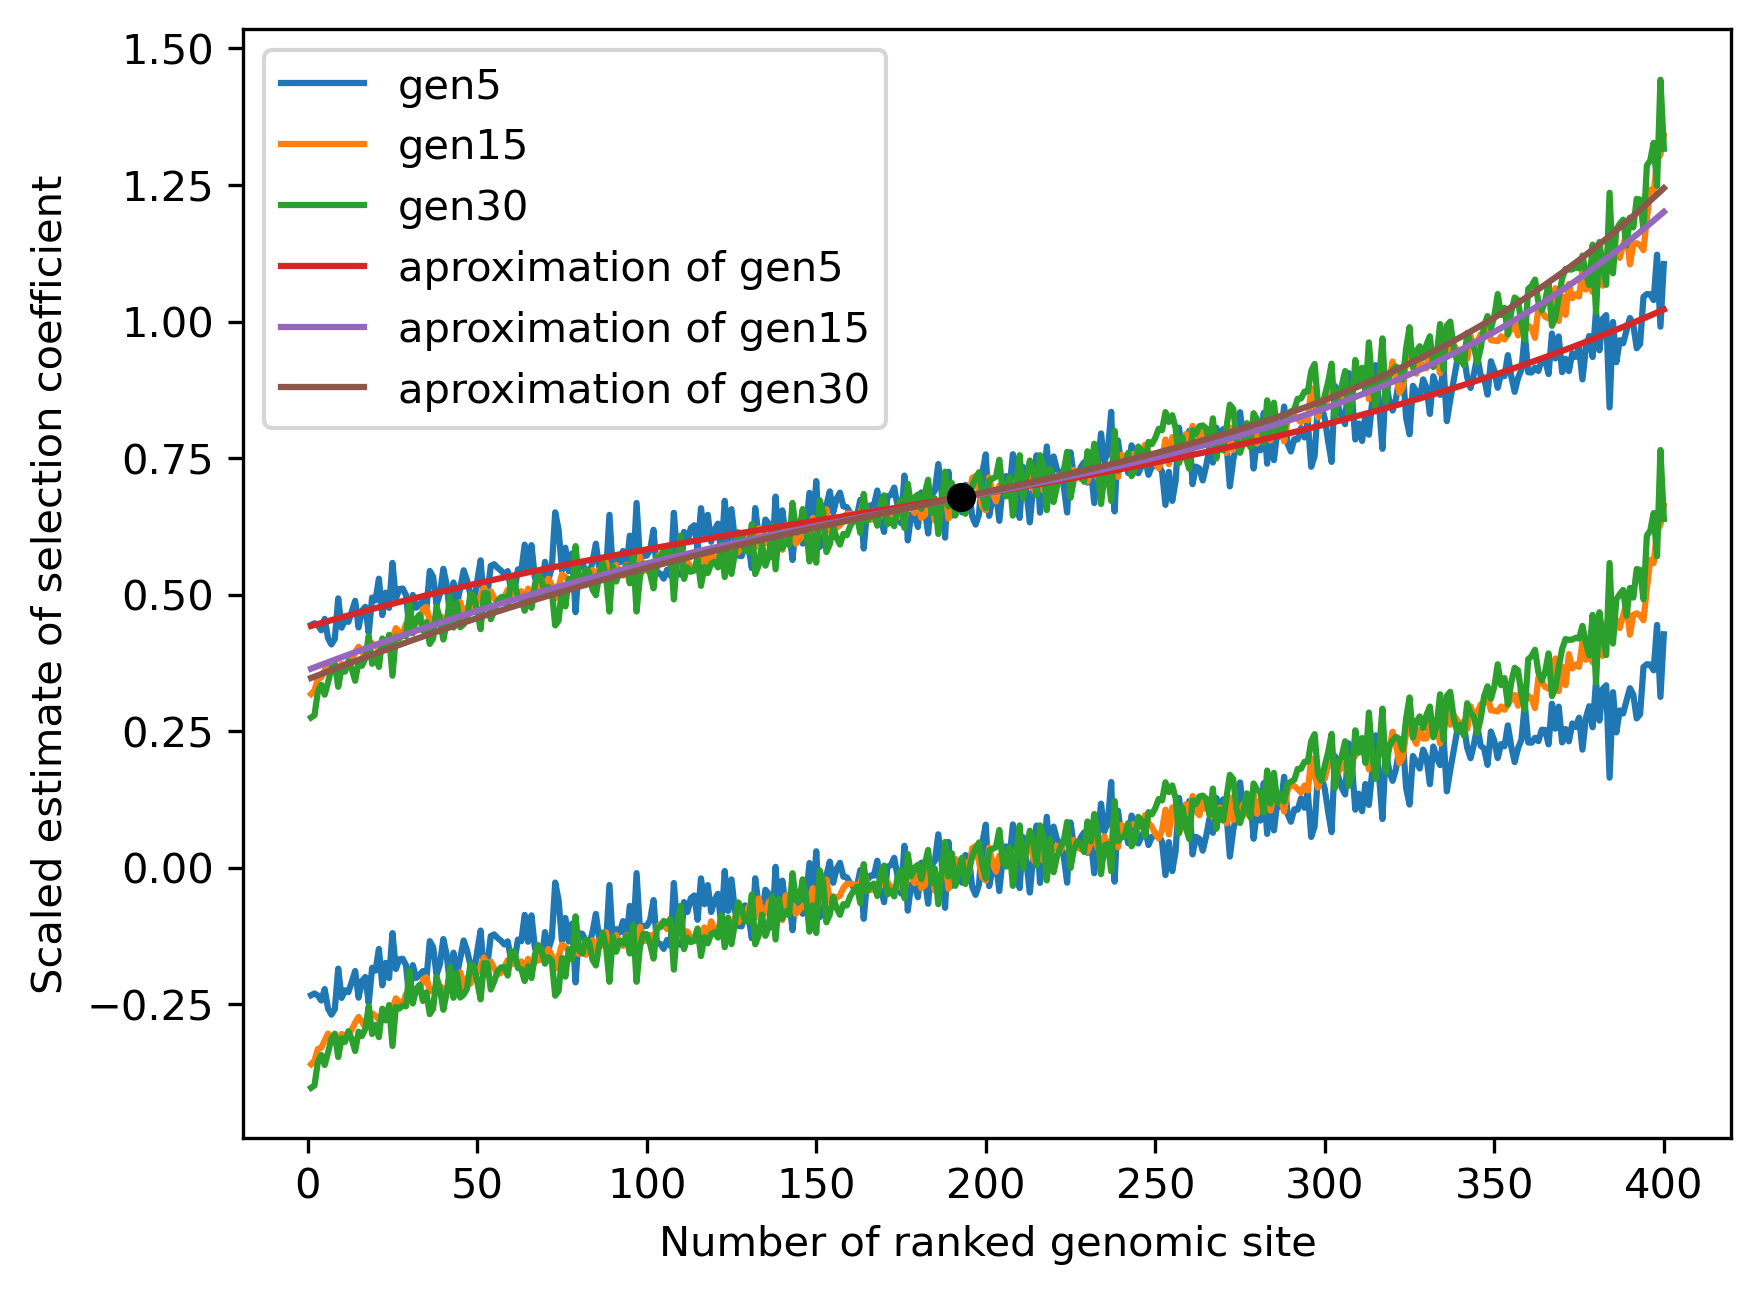

In [47]:
fn = fln.copy()
fn.index = range(1,401)
fn.columns = [0,1,2,'mean']
# polys[0](range(1,401))
line = np.poly1d(np.polyfit(np.linspace(-0.1,0.1,400),fln_real.iloc[:,0],1))
plt.figure(dpi=300)
# plt.plot(x0,0,'ok',label='точка пересечения...')
for i in range(3):
    plt.plot(range(1,401),fn[i],color=f'C{i}',label=f'gen{what.tsecs[i]}')
    plt.plot(range(1,401),fn[i]-C,color=f'C{i}')
for i in range(3):
    plt.plot(range(1,401),polys[i](range(1,401)),color=f'C{i+3}',label=f'aproximation of gen{what.tsecs[i]}')
plt.plot(x0,C,'ok')
# plt.grid()
plt.legend()
plt.xlabel('Number of ranked genomic site')
plt.ylabel('Scaled estimate of selection coefficient')#'$\\log \\left( \\frac{f_i}{1-f_i} \\right)$')


# plt.scatter(fln_real['real_s'],fln_real[5]-C)
# plt.plot(np.linspace(-0.1,0.1,10),line(np.linspace(-0.1,0.1,10))-C,'r')
# plt.grid()
# plt.xlabel('simulated s')
# plt.ylabel('measured $\\beta$s')

In [63]:
what.real_s.loc['s']

1     -0.090255
2     -0.042178
3      0.044193
4     -0.095677
5     -0.058815
         ...   
396    0.068318
397   -0.068103
398    0.047454
399   -0.016337
400   -0.075694
Name: s, Length: 400, dtype: float64

Text(0, 0.5, 'Estimated selection coefficient, $\\beta s$')

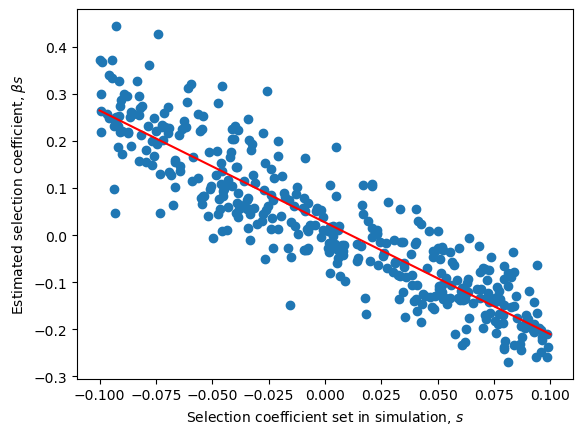

In [78]:
fn = -np.log(fN)
fn.sort_index(inplace=True)
plt.scatter(what.real_s,fn.loc[:,5]-C)
plt.plot(np.linspace(-0.1,0.1,400),np.poly1d(np.polyfit(what.real_s.loc['s'],fn.loc[:,5],1))(np.linspace(-0.1,0.1,400))-C,'r')
plt.xlabel('Selection coefficient set in simulation, $s$')
plt.ylabel('Estimated selection coefficient, $\\beta s$')

In [73]:
lines

{0: poly1d([-0.00128904, -0.44319502]),
 1: poly1d([-0.00173908, -0.3624208 ]),
 2: poly1d([-0.00187251, -0.3405378 ])}

In [77]:
np.save('heat_list.npy',heat_list)

In [21]:
heat_list = np.load('heat_list.npy',allow_pickle=True)
loaded_list = heat_list.tolist()
loaded_list

{'r5M1run5L40': -0.951748622284241,
 'r5M1run10L40': -0.9652329427449642,
 'r5M1run50L40': -0.9806690372208298,
 'r5M1run5L100': -0.8841353260169087,
 'r5M1run10L100': -0.9369608898503173,
 'r5M1run50L100': -0.9594218095264931,
 'r5M1run5L400': -0.8238365767487154,
 'r5M1run10L400': -0.8850124035270639,
 'r5M1run50L400': -0.9606700476616991,
 'r50M1run5L40': -0.9570941576083521,
 'r50M1run10L40': -0.9648699480078848,
 'r50M1run50L40': -0.9807384572048706,
 'r50M1run5L100': -0.9340993931155223,
 'r50M1run10L100': -0.9453046990201726,
 'r50M1run50L100': -0.9516180650195546,
 'r50M1run5L400': -0.8316919648293016,
 'r50M1run10L400': -0.9053964366093065,
 'r50M1run50L400': -0.964280671731898,
 'r100M1run5L40': -0.9740443118785692,
 'r100M1run10L40': -0.9764024242854298,
 'r100M1run50L40': -0.9808141761104884,
 'r100M1run5L100': -0.947776255236349,
 'r100M1run10L100': -0.9594355356317092,
 'r100M1run50L100': -0.9597437707825591,
 'r100M1run5L400': -0.8554082814246438,
 'r100M1run10L400': -0.

In [29]:
frm = list(heat_list.values())

i = 0
heat_dict = {}

for L in [40,100,400]:
    heat_dict[f'L={L}'] = {}

    for run in [5,10,50]:
#         heat_dict[L][run] = {}
        heat_dict[f'L={L}'][f'run={run}'] = frm[i]
        i+=1
#         for r in [5,50,100]:
#             heat_dict[L][run][r] = {}
#             for M in [1,3,10]:
#                 heat_dict[L][run][r][M] = frm[i]
#                 i+=1
# df = pd.DataFrame(heat_dict)



<AxesSubplot:>

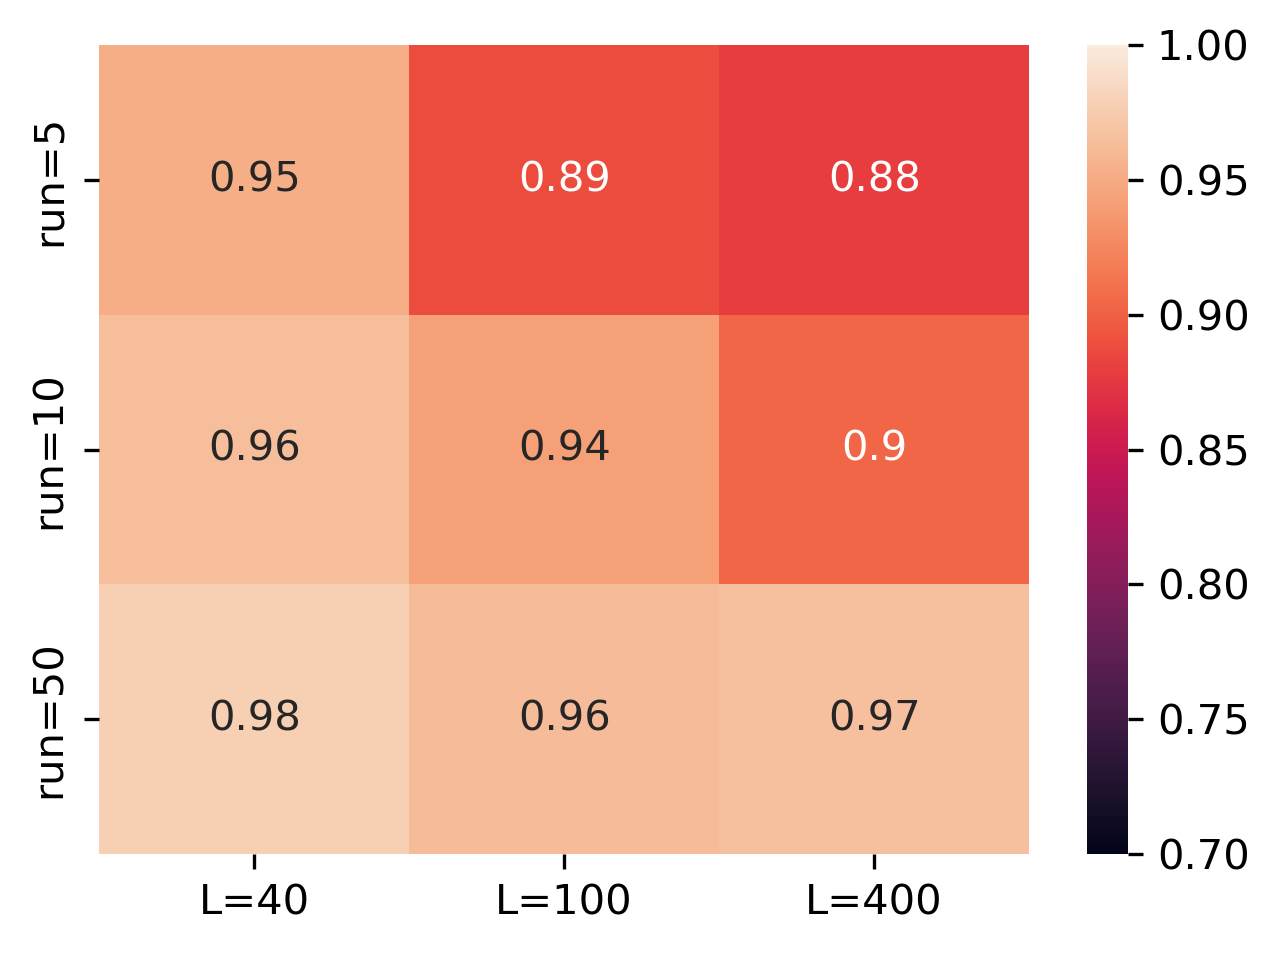

In [33]:
df = pd.DataFrame(heat_dict)
plt.figure(figsize=(5,3.5),dpi=300)
sns.heatmap(-1*df,annot= True,vmax=1,vmin=0.7)
# plt.xlabel('r=0')
# plt.ylabel('M=0')

In [72]:
heat_dict

{40: {5: -0.9523803179389008,
  10: -0.9645385313684188,
  50: -0.9774592495810941},
 100: {5: -0.888320156545365,
  10: -0.9423960350296602,
  50: -0.9633735294656628},
 400: {5: -0.8782906600031234,
  10: -0.9035033413268386,
  50: -0.9656402076616871}}

In [78]:
frm = list(heat_list.values())
monstr = {}
i=0
for M in [1,3,10]:
    monstr[M] = {}
    for r in [5,50,100]:
        submonstr = {}
        for L in [40,100,400]:
            submonstr[f'L={L}'] = {}
            for run in [5,10,50]:
                submonstr[f'L={L}'][f'run={run}'] = frm[i]
                i+=1
        monstr[M][r] = pd.DataFrame(submonstr)
                

<AxesSubplot:>

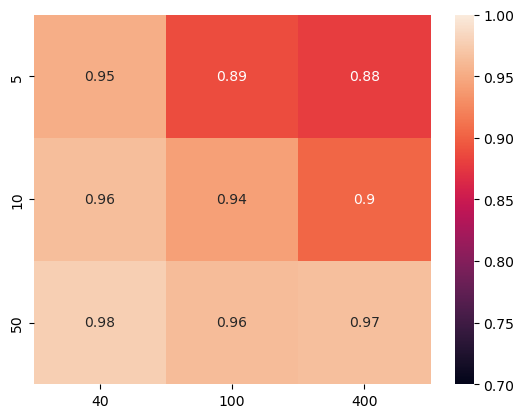

In [73]:
# plt.figure(dpi=300)
sns.heatmap(-1*pd.DataFrame(heat_dict), annot= True,vmax=1,vmin=0.7)

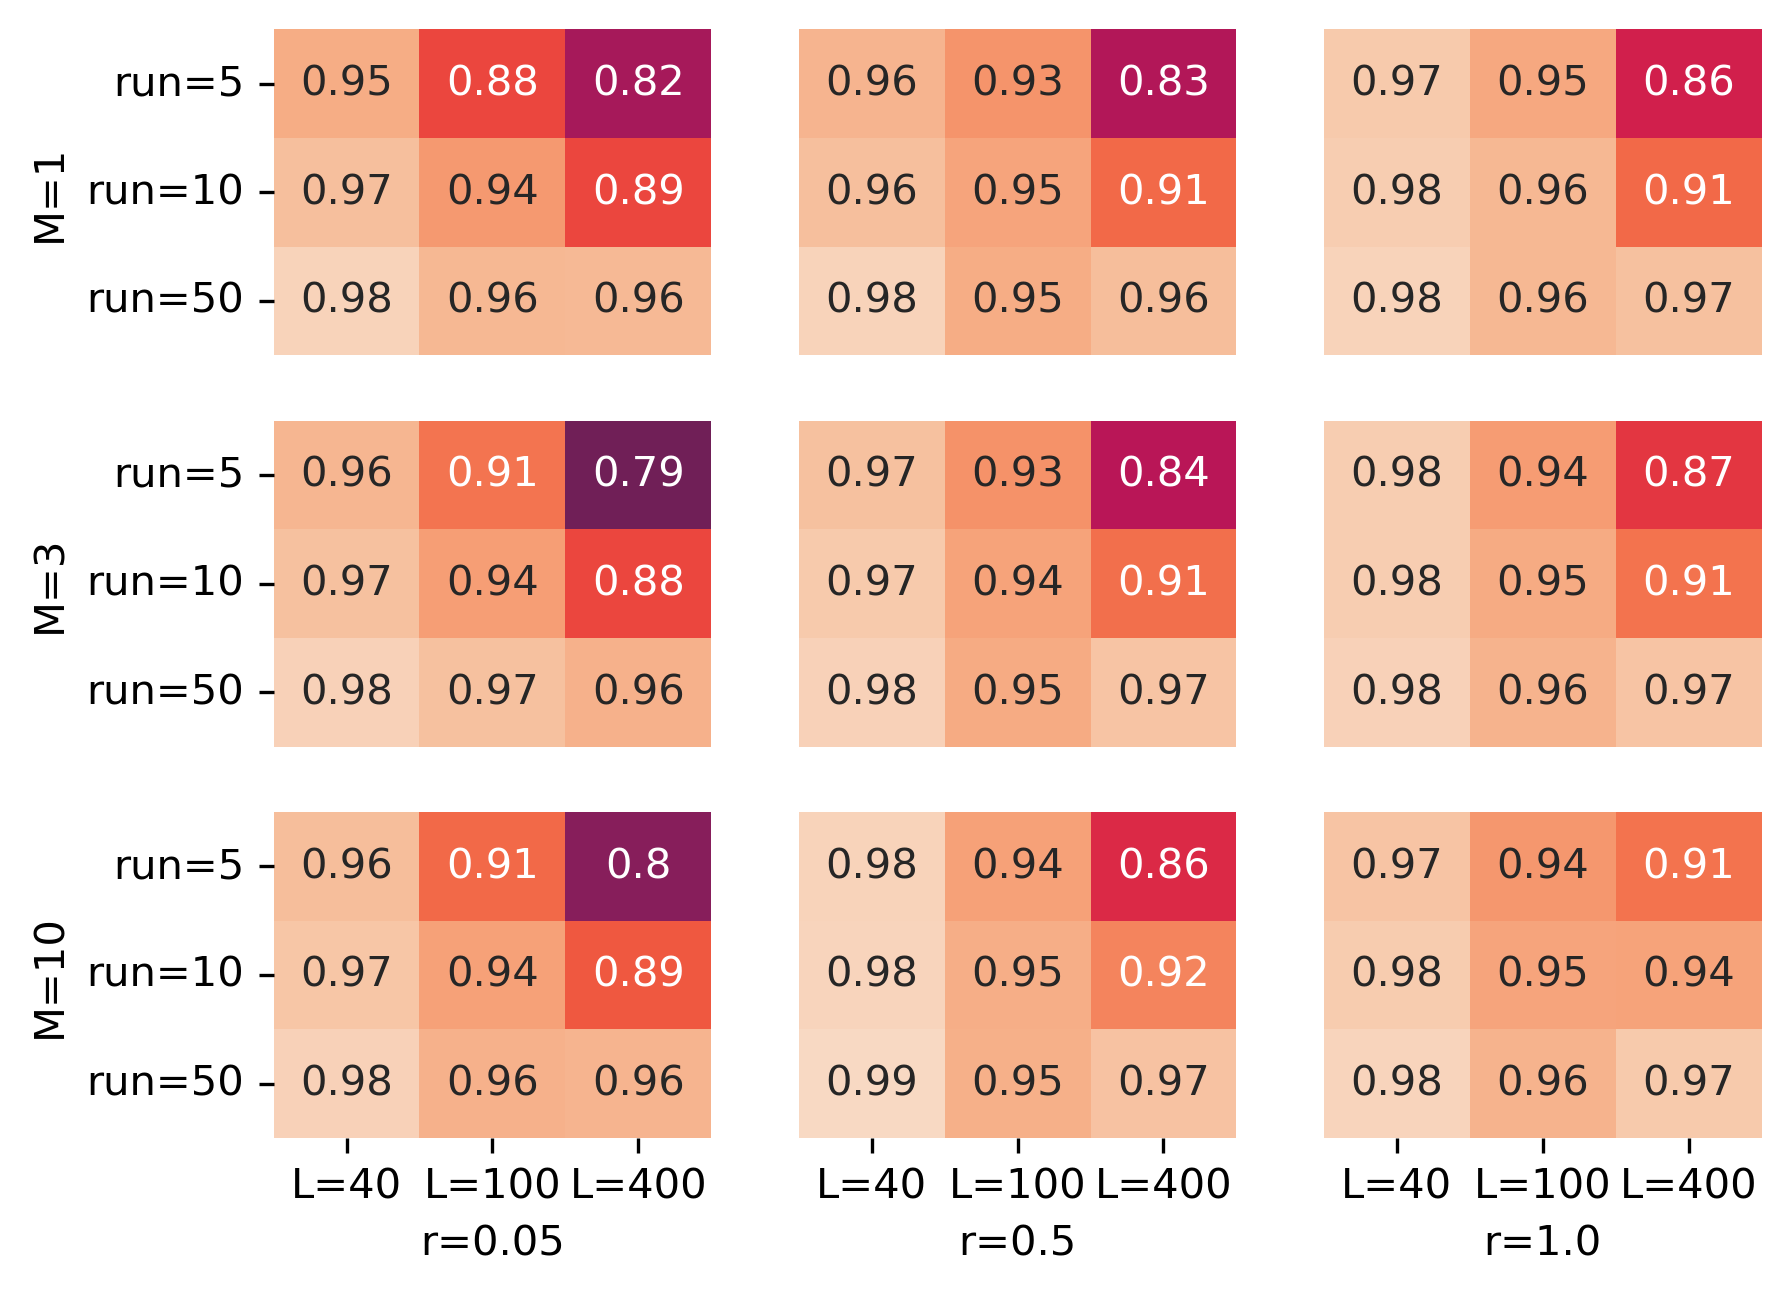

In [79]:
j = 1
plt.figure(dpi=300)
for M in [1,3,10]:
    for r in [5,50,100]:
        ax = plt.subplot(3,3,j)
        if j not in [1,4,7]:
            if j not in [7,8,9]:
                sns.heatmap(-1*monstr[M][r],annot= True,vmax=1,vmin=0.7,
                            cbar=False,yticklabels=False,xticklabels=False)
            else:
                sns.heatmap(-1*monstr[M][r],annot= True,vmax=1,vmin=0.7,
                            cbar=False,yticklabels=False,xticklabels=True)
                plt.xlabel(f'r={r/100}')
        else:
            if j not in [7,8,9]:
                sns.heatmap(-1*monstr[M][r],annot= True,vmax=1,vmin=0.7,
                            cbar=False,yticklabels=True,xticklabels=False)
                plt.ylabel(f'M={M}')
            else:
                sns.heatmap(-1*monstr[M][r],annot= True,vmax=1,vmin=0.7,
                            cbar=False,yticklabels=True,xticklabels=True)
                plt.ylabel(f'M={M}')
                plt.xlabel(f'r={r/100}')
#         ax.set_title('$\\beta \\cdot s = \\ln{f}$')
        j+=1


In [35]:
plt.figure(figsize=(5,3.5),dpi=150)
sns.heatmap(-df,annot=True,vmax=1,vmin=0,cmap='')

plt.xlabel('L')
plt.ylabel('run');
# plt.title('')

ValueError: 'Specture' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

<Figure size 750x525 with 0 Axes>

In [17]:
dfN = what.FrameN.loc[:,range(1,501)].dropna(axis=1)

In [113]:
dfN.T

,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
1,0.49675,0.50565,0.50215,0.50645,0.50205,0.49890,0.49480,0.49750,0.49625,0.5000,...,0.50205,0.50475,0.49980,0.50020,0.50125,0.50025,0.50165,0.49135,0.50035,0.50260
50,0.60225,0.61695,0.82425,0.49510,0.66560,0.42635,0.29765,0.62850,0.23865,0.5997,...,0.25780,0.55425,0.13940,0.68530,0.71710,0.23855,0.36635,0.77585,0.46355,0.75765
100,0.64560,0.63995,0.85035,0.50585,0.72440,0.42380,0.26405,0.61485,0.20090,0.5883,...,0.23070,0.58620,0.11835,0.68965,0.70800,0.25890,0.39180,0.74705,0.46690,0.74110
150,0.67270,0.62975,0.86300,0.51470,0.76045,0.42335,0.24395,0.60695,0.16430,0.5935,...,0.21705,0.60265,0.11035,0.68530,0.69565,0.27770,0.40415,0.72765,0.47335,0.72230
200,0.69220,0.62410,0.88045,0.51665,0.79185,0.41430,0.21720,0.59765,0.12735,0.5951,...,0.20525,0.61630,0.10035,0.68335,0.68370,0.29710,0.41630,0.69835,0.48080,0.70290
250,0.69585,0.61575,0.88425,0.51160,0.79585,0.41575,0.21990,0.60415,0.11990,0.6000,...,0.20000,0.61160,0.10000,0.68840,0.68840,0.29585,0.41160,0.70415,0.48425,0.70415
300,0.69945,0.61905,0.88095,0.51850,0.79945,0.41905,0.21960,0.60055,0.11960,0.6000,...,0.20000,0.61850,0.10000,0.68150,0.68150,0.29945,0.41850,0.70055,0.48095,0.70055
350,0.70000,0.60305,0.89695,0.50305,0.80000,0.40305,0.20305,0.60000,0.10305,0.6000,...,0.20000,0.60305,0.10000,0.69695,0.69695,0.30000,0.40305,0.70000,0.49695,0.70000
400,0.70000,0.60065,0.89935,0.50065,0.80000,0.40065,0.20065,0.60000,0.10065,0.6000,...,0.20000,0.60065,0.10000,0.69935,0.69935,0.30000,0.40065,0.70000,0.49935,0.70000
450,0.70000,0.60120,0.89880,0.50120,0.80000,0.40120,0.20120,0.60000,0.10120,0.6000,...,0.20000,0.60120,0.10000,0.69880,0.69880,0.30000,0.40120,0.70000,0.49880,0.70000


Text(0.5, 1.0, '$f_0=0.5,r=0$,L=1000')

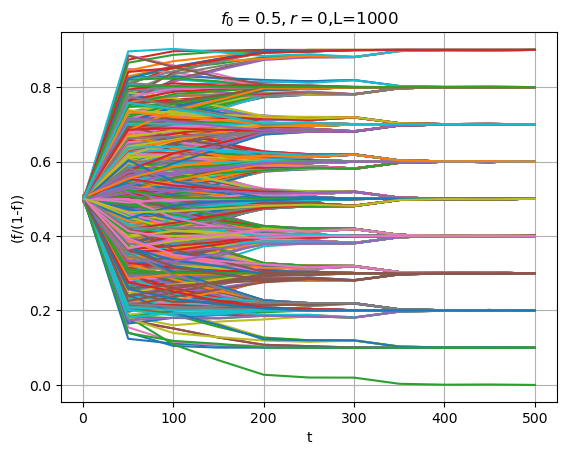

In [114]:
for i in range(1,L+1):#[117,4,98,194,86,140,175,181,111]:
    plt.plot(dfN.loc[i])
#     plt.plot(dfN.loc[i]/(1-dfN.loc[i]))#,'--.',label = f'{i}')
plt.grid()
# plt.legend()
# plt.yscale('log')
plt.xlabel('t')
plt.ylabel('(f/(1-f))')
# plt.ylim(0.1,1)
# plt.xlim(0,400)
plt.title('$f_0=0.5,r=0$,L=1000')

In [115]:
0.004/40

0.0001

In [116]:
ttt = [50,150,200] # рассматриваемые периоды времени

dfBeta = dfN.loc[:,ttt].copy()
tribet = np.log((1-dfBeta)/dfBeta)
tribet.loc[:,'mean'] = tribet.T.mean()
tribet.sort_values('mean',ascending=False,inplace=True)

In [117]:
tribet.dropna(inplace=True)
# tribet.index=range(1,L+1)
# polutribet = tribet[abs(tribet['mean'])>=0.2]

In [118]:

# tribet = polutribet.dropna()
# L=587
# tribet

In [130]:
j=4
chest = {}
# for i in range(3,7):
chest[j] = polysearch(j)

Text(0.5, 1.0, '$f_0=0.5,r=0,\\mu = 2.2 \\cdot 10^{-10},L=1000$')

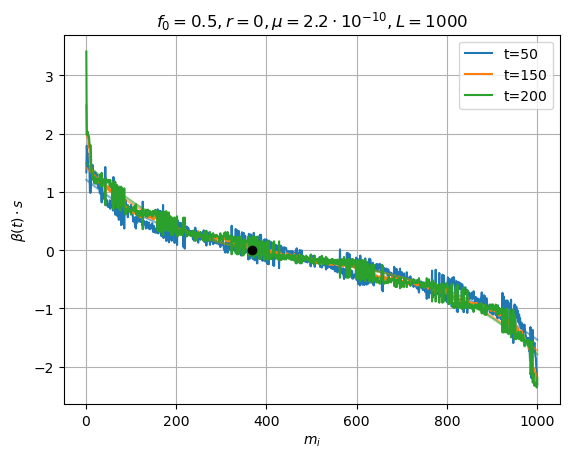

In [131]:
# j=5
# colors=['black','magenta','cyan','indigo']
# chest = {}
# chest[j] = polysearch(j)

for i in range(3):
    plt.plot(range(1,L+1),-chest[j][2]+tribet.loc[:,ttt[i]],color=f'C{i}',label=f't={ttt[i]}')
    plt.plot(range(1,L+1),-chest[j][2]+chest[j][0][i](range(1,L+1)),color=f'C{i}',alpha=0.6)
plt.plot(chest[j][1],0,'ok')
# for j in range(3,7):
#     for i in range(3):
#         plt.plot(range(1,L+1),chest[j][0][i](range(1,L+1)),color=f'C{i}',alpha=0.4)
#     plt.plot(chest[j][1],chest[j][2],'o',color=colors[j-3],label=f'deg={j}')
# plt.grid()
plt.legend()
plt.xlabel('$m_i$')
plt.ylabel('$\\beta(t) \\cdot s$')
plt.title('$f_0=0.5,r=0,\mu = 2.2 \cdot 10^{-10},L=1000$')
# plt.xlim(42,52)
# plt.ylim(-1.5,1.5)

In [23]:
def forsmake(polyd,C):
    fors = tribet.loc[:,ttt].sort_index().copy() - C
    polfors={}
    for i in range(3):
        polfors[i] = polyd[i](range(1,L+1))
    polfors = pd.DataFrame(polfors)
    polfors.index=range(1,L+1)
    polfors.columns=ttt
    polfors.loc[:,'real_s'] = what.mat['s'][0]
    fors.loc[:,'real_s'] = what.mat['s'][0]
    return fors

In [133]:
# fors.T/fors.real_s
# fors.corr()

In [134]:
# posfors = fors[fors[100]>=0]
# negfors = fors[fors[100]<0]

In [135]:
# for i in range(3):
#     plt.plot(abs(fors.T.iloc[i]))
# plt.grid()
# plt.xlabel('m_i')
# plt.ylabel(f'$\\beta$')

In [136]:
# for i in range(3):
#     plt.plot(posfors.T.iloc[i])
#     plt.plot(abs(negfors.T.iloc[i]))
# plt.grid()
# plt.xlabel('m_i')
# plt.ylabel(f'$\\beta$')

In [22]:
forses = []
# for i in range(3,7):
forses.append(forsmake(chest[j][0],chest[j][2]))

t = ttt[1]
# plt.scatter(fors.real_s,fors.loc[:,t]) #real
# plt.scatter(fors.real_s,polfors.loc[:,t]) #poly
# for i in range(4):
plt.scatter(forses[0].real_s,forses[0].loc[:,t])
plt.plot(np.linspace(-0.05,0.05,L),np.poly1d(np.polyfit(forses[0].real_s,forses[0].loc[:,t],1))(np.linspace(-0.05,0.05,L)),'r')
# i=1
# plt.scatter(forses[i].real_s,forses[i].loc[:,t])
# plt.plot(np.linspace(-0.2,0.2,L),np.poly1d(np.polyfit(forses[i].real_s,forses[i].loc[:,t],1))(np.linspace(-0.2,0.2,L)),label=f'deg={i+3},C={chest[i+3][2]}')

# plt.grid()
# plt.xlabel('real s')
# plt.ylabel('$\\beta(t) \\cdot s$')
# plt.title('$f_0=0.5,r=0.027,\mu = 1.3 \cdot 10^{-6},L=400$, run=100 \n'+f't={t}')
# plt.ylim(-3.4,3)
# plt.xlim(-0.05,0.05)
# plt.legend()

NameError: name 'forsmake' is not defined

In [84]:
forses

NameError: name 'forses' is not defined

In [69]:
df = pd.DataFrame(what.mat['Data'][0][0][0][0]).iloc[:14,:20]
df.index = [f'особь {i+1}' for i in range(14)]
df.columns = range(1,21)
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
особь 1,1,1,0,0,1,0,0,1,1,1,0,1,1,1,1,0,0,0,1,1
особь 2,0,0,0,1,0,0,0,1,0,0,1,1,0,1,1,0,1,1,1,0
особь 3,1,0,0,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,0
особь 4,1,0,1,0,1,0,1,1,1,1,0,1,1,1,0,1,0,1,1,1
особь 5,1,1,1,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0
особь 6,1,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0,1,0,1
особь 7,1,1,0,0,1,1,0,1,1,1,0,1,1,0,1,0,1,1,1,0
особь 8,1,1,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0
особь 9,1,1,0,0,1,1,0,1,1,0,1,1,0,1,0,0,0,1,0,1
особь 10,0,0,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,0,0


In [89]:
plt.plot(range(L),odf_1.sum().sort_values()/numseqs,label=f't={tsecs[0]}')
plt.plot(range(L),odf_2.sum().sort_values()/numseqs,label=f't={tsecs[1]}')
plt.plot(range(L),odf_3.sum().sort_values()/numseqs,label=f't={tsecs[2]}')

NameError: name 'odf_1' is not defined

In [ ]:
L=40
numseqs = 10000#len(ts['Data'][0])*1000
frst=np.array(ts['Data'][0][0][0][0])
for t in range(1,4):
    for r in range(3):
        frst=np.append(frst,ts['Data'][0][r][0][t])
df_1=pd.DataFrame(np.reshape(frst,(numseqs,L))[rn.sample(range(numseqs),3000)])
scnd=np.array(ts['Data'][0][0][0][10])
for t in range(11,14):
    for r in range(3):
        scnd=np.append(scnd,ts['Data'][0][r][0][t])
df_2=pd.DataFrame(np.reshape(scnd,(numseqs,L))[rn.sample(range(numseqs),3000)])
thrd=np.array(ts['Data'][0][0][0][20])
for t in range(21,24):
    for r in range(3):
        thrd=np.append(thrd,ts['Data'][0][r][0][t])
df_3=pd.DataFrame(np.reshape(thrd,(numseqs,L))[rn.sample(range(numseqs),3000)])
bs1 = np.log((1-(df_1.sum()/3000))/(df_1.sum()/3000)).sort_values(ascending=False).values
bs2 = np.log((1-(df_2.sum()/3000))/(df_2.sum()/3000)).sort_values(ascending=False).values
bs3 = np.log((1-(df_3.sum()/3000))/(df_3.sum()/3000)).sort_values(ascending=False).values
plt.plot(range(L),bs1,label=f't=0-4')
plt.plot(range(L),bs2,label=f't=10-14')
plt.plot(range(L),bs3,label=f't=20-24')
plt.legend()
plt.grid()
plt.xlabel('$m_i$')
plt.ylabel('$\\beta(t) \\cdot s_i$')
yDict = {'y_1':bs1,
         'y_2':bs2,
         'y_3':bs3}
x=np.arange(1,L,0.01)
mi = range(L)
polyDict = dict()
for n in range(1,4):
    polyDict[f'line_{n}']=np.poly1d(np.polyfit(mi,yDict[f'y_{n}'],4))
absDict=dict()
ncount=1
for i in range(1,4):
    for j in range(i+1,4):
        absDict[f'abs{ncount}']=[]
        for z in x:
            absDict[f'abs{ncount}'].append((polyDict[f'line_{j}'](z)-polyDict[f'line_{i}'](z))**2)
        ncount+=1
absdf=pd.DataFrame(absDict,index=x)
absdf['sum']=absdf.sum(axis=1)
x0=absdf[absdf['sum']==absdf['sum'].min()].index[0]
C=np.mean([polyDict[f'line_{n}'](x0) for n in range(1,4)])


In [ ]:
odf_1.sum()/numseqs

In [ ]:
test_list = []
for t in range(3):
    df=pd.DataFrame(ts['Data'][0][0][0][t])
    test_list.append(df.sum().to_list())
test_list.append(ts['s'][0])
pd.DataFrame(test_list)

In [ ]:
yDict

In [23]:
class error_check(L):
    self.L=L
    numseqs = len(ts['Data'][0])*1000
    ofrst=np.array(ts['Data'][0][0][0][0])
    for r in range(1,len(ts['Data'][0])):
        ofrst=np.append(ofrst,ts['Data'][0][r][0][0])
    odf_1=pd.DataFrame(np.reshape(ofrst,(numseqs,L)))
    oscnd=np.array(ts['Data'][0][0][0][1])
    for r in range(1,len(ts['Data'][0])):
        oscnd=np.append(oscnd,ts['Data'][0][r][0][1])
    odf_2=pd.DataFrame(np.reshape(oscnd,(numseqs,L)))
    othrd=np.array(ts['Data'][0][0][0][2])
    for r in range(1,len(ts['Data'][0])):
        othrd=np.append(othrd,ts['Data'][0][r][0][2])
    odf_3=pd.DataFrame(np.reshape(othrd,(numseqs,L)))

    obs1 = np.log((1-(odf_1.sum()/numseqs))/(odf_1.sum()/numseqs)).sort_values(ascending=False).values
    obs2 = np.log((1-(odf_2.sum()/numseqs))/(odf_2.sum()/numseqs)).sort_values(ascending=False).values
    obs3 = np.log((1-(odf_3.sum()/numseqs))/(odf_3.sum()/numseqs)).sort_values(ascending=False).values
    plt.plot(range(L),obs1,label='1')
    plt.plot(range(L),obs2,label='2')
    plt.plot(range(L),obs3,label='3')
    yDict = {'y_1':obs1,
             'y_2':obs2,
             'y_3':obs3}
    x=np.arange(1,L,0.01)
    mi = range(L)
    polyDict = dict()
    for n in range(1,4):
        polyDict[f'line_{n}']=np.poly1d(np.polyfit(mi,yDict[f'y_{n}'],4))
    absDict=dict()
    ncount=1
    for i in range(1,4):
        for j in range(i+1,4):
            absDict[f'abs{ncount}']=[]
            for z in x:
                absDict[f'abs{ncount}'].append((polyDict[f'line_{j}'](z)-polyDict[f'line_{i}'](z))**2)
            ncount+=1
    absdf=pd.DataFrame(absDict,index=x)
    absdf['sum']=absdf.sum(axis=1)
    x0=absdf[absdf['sum']==absdf['sum'].min()].index[0]
    C=np.mean([polyDict[f'line_{n}'](x0) for n in range(1,4)])

NameError: name 'self' is not defined

In [15]:
ts['Data'][0][0][0]

array([array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
       array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
       array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)], dtype=object)

In [16]:
len(ts['Data'][0])

100

In [19]:
test_list = []
for t in range(3):
    df=pd.DataFrame(ts['Data'][0][2][0][t])
    test_list.append(df.sum().to_list())
test_list.append(ts['s'][0])
pd.DataFrame(test_list)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,49.000000,86.000000,137.000000,15.000000,48.000000,21.000000,42.000000,28.000000,94.000000,30.000000,...,103.000000,11.000000,11.000000,75.000000,24.00000,11.000000,40.000000,27.000000,73.000000,36.000000
1,21.000000,70.000000,274.000000,2.000000,83.000000,1.000000,18.000000,7.000000,62.000000,2.000000,...,153.000000,0.000000,1.000000,77.000000,7.00000,5.000000,21.000000,9.000000,40.000000,107.000000
2,0.000000,51.000000,286.000000,0.000000,47.000000,0.000000,0.000000,0.000000,7.000000,0.000000,...,472.000000,0.000000,0.000000,43.000000,0.00000,2.000000,0.000000,0.000000,8.000000,463.000000
3,0.006919,0.178785,0.106184,-0.087042,-0.111582,0.074489,-0.133144,-0.043023,0.047221,-0.035228,...,0.103108,-0.016254,-0.170216,0.040995,-0.02576,-0.197429,-0.181348,-0.032503,0.151306,-0.026793


In [ ]:
pd.DataFrame(test_list)

In [20]:
for i,val in enumerate(pd.DataFrame(test_list).sum()):
    print(f'{i}:{val}')

0:70.00691915353863
1:207.1787850415259
2:697.1061839037587
3:16.912958337586844
4:177.88841814530466
5:22.074488834094986
6:59.866855681240025
7:34.956976986586014
8:163.04722093890112
9:31.964772037943497
10:16.800985952480353
11:508.1536128729488
12:254.1539790153506
13:39.920163875746596
14:36.03583274608589
15:714.191370766406
16:175.13803752885053
17:29.826030175622876
18:17.917897785886947
19:32.9151737763869
20:673.1289865356414
21:92.0504732151841
22:24.84419108556547
23:27.80021152446771
24:712.1768664931423
25:80.85660030309008
26:34.96863861046646
27:23.93859577605942
28:911.1479140337589
29:18.971440724940916
30:733.1315005937291
31:703.0871407352904
32:6.847690677673649
33:74.03855366908384
34:24.85190251908207
35:9.831013636690871
36:160.13248210227616
37:25.98575424591208
38:15.8648049916011
39:22.0191901168372
40:117.03539432873694
41:161.1094452676303
42:226.06233818320277
43:120.02308270379137
44:143.87129890662806
45:55.896233412487206
46:184.00242185294755
47:77.95

In [21]:
run=0
time=1
df=pd.DataFrame(ts['Data'][0][run][0][time])
dfsum = df.sum()
for i,val in enumerate(dfsum):
    if val==0:
        print(i)

In [22]:
14+24

38

In [21]:
#0-14 38-52 76-90
frst=np.array(ts['Data'][0][0][0][0])
for t in range(0,14):
    for r in range(3):
        frst=np.append(frst,ts['Data'][0][r][0][t])
df_1=pd.DataFrame(np.reshape(frst,(43000,100))[rn.sample(range(43000),2000)])
scnd=np.array(ts['Data'][0][0][0][38])
for t in range(38,52):
    for r in range(3):
        scnd=np.append(scnd,ts['Data'][0][r][0][t])
df_2=pd.DataFrame(np.reshape(scnd,(43000,100))[rn.sample(range(43000),2000)])
thrd=np.array(ts['Data'][0][0][0][76])
for t in range(76,90):
    for r in range(3):
        thrd=np.append(thrd,ts['Data'][0][r][0][t])
df_3=pd.DataFrame(np.reshape(thrd,(43000,100))[rn.sample(range(43000),2000)])
bs1 = np.log((1-(df_1.sum()/2000))/(df_1.sum()/2000)).sort_values(ascending=False).values
bs2 = np.log((1-(df_2.sum()/2000))/(df_2.sum()/2000)).sort_values(ascending=False).values
bs3 = np.log((1-(df_3.sum()/2000))/(df_3.sum()/2000)).sort_values(ascending=False).values
plt.plot(range(100),bs1,label='1')
plt.plot(range(100),bs2,label='2')
plt.plot(range(100),bs3,label='3')
plt.legend()

IndexError: index 3 is out of bounds for axis 0 with size 3

In [22]:
ofrst=np.array(ts['Data'][0][0][0][10])
for r in range(1,3):
    ofrst=np.append(ofrst,ts['Data'][0][r][0][10])
odf_1=pd.DataFrame(np.reshape(ofrst,(3000,100)))
oscnd=np.array(ts['Data'][0][0][0][45])
for r in range(1,3):
    oscnd=np.append(oscnd,ts['Data'][0][r][0][45])
odf_2=pd.DataFrame(np.reshape(oscnd,(3000,100)))
othrd=np.array(ts['Data'][0][0][0][90])
for r in range(1,3):
    othrd=np.append(othrd,ts['Data'][0][r][0][90])
odf_3=pd.DataFrame(np.reshape(othrd,(3000,100)))
obs1 = np.log((1-(odf_1.sum()/3000))/(odf_1.sum()/3000)).sort_values(ascending=False).values
obs2 = np.log((1-(odf_2.sum()/3000))/(odf_2.sum()/3000)).sort_values(ascending=False).values
obs3 = np.log((1-(odf_3.sum()/3000))/(odf_3.sum()/3000)).sort_values(ascending=False).values
plt.plot(range(100),obs1,label='1')
plt.plot(range(100),obs2,label='2')
plt.plot(range(100),obs3,label='3')
plt.legend()

IndexError: index 10 is out of bounds for axis 0 with size 3

In [86]:
yDict = {'y_1':bs1,
         'y_2':bs2,
         'y_3':bs3,}

In [133]:
ts['Data'][0]

array([array([[array([[0, 0, 0, ..., 0, 1, 0],
                      [0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 0, 0],
                      ...,
                      [0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 1, 0],
                      [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]], dtype=object),
       array([[array([[0, 0, 0, ..., 0, 1, 0],
                      [0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 0, 0],
                      ...,
                      [0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 1, 0],
                      [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]], dtype=object),
       array([[array([[0, 0, 0, ..., 0, 1, 0],
                      [0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 0, 0],
                      ...,
                      [0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 1, 0],
                      [0, 0, 0, ..., 0, 0, 0]], dtype=ui

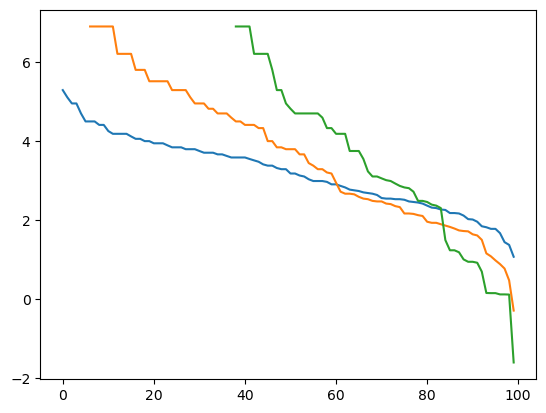

In [23]:
L=100
numseqs = len(ts['Data'][0])*1000
ofrst=np.array(ts['Data'][0][0][0][0])
for r in range(1,len(ts['Data'][0])):
    ofrst=np.append(ofrst,ts['Data'][0][r][0][0])
odf_1=pd.DataFrame(np.reshape(ofrst,(numseqs,L)))
oscnd=np.array(ts['Data'][0][0][0][1])
for r in range(1,len(ts['Data'][0])):
    oscnd=np.append(oscnd,ts['Data'][0][r][0][1])
odf_2=pd.DataFrame(np.reshape(oscnd,(numseqs,L)))
othrd=np.array(ts['Data'][0][0][0][2])
for r in range(1,len(ts['Data'][0])):
    othrd=np.append(othrd,ts['Data'][0][r][0][2])
odf_3=pd.DataFrame(np.reshape(othrd,(numseqs,L)))

obs1 = np.log((1-(odf_1.sum()/numseqs))/(odf_1.sum()/numseqs)).sort_values(ascending=False).values
obs2 = np.log((1-(odf_2.sum()/numseqs))/(odf_2.sum()/numseqs)).sort_values(ascending=False).values
obs3 = np.log((1-(odf_3.sum()/numseqs))/(odf_3.sum()/numseqs)).sort_values(ascending=False).values
plt.plot(range(L),obs1,label='1')
plt.plot(range(L),obs2,label='2')
plt.plot(range(L),obs3,label='3')
yDict = {'y_1':obs1,
         'y_2':obs2,
         'y_3':obs3}
x=np.arange(1,L,0.01)
mi = range(L)
polyDict = dict()
for n in range(1,4):
    polyDict[f'line_{n}']=np.poly1d(np.polyfit(mi,yDict[f'y_{n}'],4))
absDict=dict()
ncount=1
for i in range(1,4):
    for j in range(i+1,4):
        absDict[f'abs{ncount}']=[]
        for z in x:
            absDict[f'abs{ncount}'].append((polyDict[f'line_{j}'](z)-polyDict[f'line_{i}'](z))**2)
        ncount+=1
absdf=pd.DataFrame(absDict,index=x)
absdf['sum']=absdf.sum(axis=1)
x0=absdf[absdf['sum']==absdf['sum'].min()].index[0]
C=np.mean([polyDict[f'line_{n}'](x0) for n in range(1,4)])


In [147]:
obs3

array([        inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,  6.90675478,  6.90675478,
        6.90675478,  6.90675478,  6.2126061 ,  6.2126061 ,  6.2126061 ,
        6.2126061 ,  5.80613848,  5.29330482,  5.29330482,  4.95482051,
        4.82028157,  4.70148996,  4.70148996,  4.70148996,  4.70148996,
        4.70148996,  4.70148996,  4.59511985,  4.32972068,  4.32972068,
        4.18459144,  4.18459144,  4.18459144,  3.74899244,  3.74899244,
        3.74899244,  3.54715129,  3.23142829,  3.10260328,  3.10

In [21]:
# grf421 = GraphsForSim3(fullL40M2r1,0.9,0.2,SearchIntersection=True)
# grf4201 = GraphsForSim3(fullL40M2r01,0.9,0.2,SearchIntersection=True)
# grf420 = GraphsForSim3(fullL40M2r0,0.9,0.2,SearchIntersection=True)

# gr_2s4201run100 = GraphsForSim2(s_L40M2r01run100,0.9,0.2,SearchIntersection=True)
# gr_3s4201run100 = GraphsForSim3(s_L40M2r01run100,0.9,0.2,SearchIntersection=True)
# gr_2s10201run100 = GraphsForSim2(s_L100M2r01run100,0.9,0.2,SearchIntersection=True)
# gr_3s10201run100 = GraphsForSim3(s_L100M2r01run100,0.9,0.2,SearchIntersection=True)
# gr_2s4201run10 = GraphsForSim2(s_L40M2r01run10,0.9,0.2,SearchIntersection=True)
# gr_3s4201run10 = GraphsForSim3(s_L40M2r01run10,0.9,0.2,SearchIntersection=True)
# gr_2s10201run10 = GraphsForSim2(s_L100M2r01run10,0.9,0.2,SearchIntersection=False) #???
# gr_3s10201run10 = GraphsForSim3(s_L100M2r01run10,0.9,0.2,SearchIntersection=False) #???

# gr_2s4205run100 = GraphsForSim2(s_L40M2r05run100,0.9,0.2,SearchIntersection=True)
# gr_3s4205run100 = GraphsForSim3(s_L40M2r05run100,0.9,0.2,SearchIntersection=True)
# gr_2s10205run100 = GraphsForSim2(s_L100M2r05run100,0.9,0.2,SearchIntersection=True)
# gr_3s10205run100 = GraphsForSim3(s_L100M2r05run100,0.9,0.2,SearchIntersection=True)
# gr_2s4205run10 = GraphsForSim2(s_L40M2r05run10,0.9,0.2,SearchIntersection=True)
# gr_3s4205run10 = GraphsForSim3(s_L40M2r05run10,0.9,0.2,SearchIntersection=True)
# gr_2s10205run10 = GraphsForSim2(s_L100M2r05run10,0.9,0.2,SearchIntersection=False) #???
# gr_3s10205run10 = GraphsForSim3(s_L100M2r05run10,0.9,0.2,SearchIntersection=False) #???

# gr_2s421run100 = GraphsForSim2(s_L40M2r1run100,0.9,0.2,SearchIntersection=True)
# gr_3s421run100 = GraphsForSim3(s_L40M2r1run100,0.9,0.2,SearchIntersection=True)
# gr_2s1021run100 = GraphsForSim2(s_L100M2r1run100,0.9,0.2,SearchIntersection=True)
# gr_3s1021run100 = GraphsForSim3(s_L100M2r1run100,0.9,0.2,SearchIntersection=True)
# gr_2s421run10 = GraphsForSim2(s_L40M2r1run10,0.9,0.2,SearchIntersection=True)
# gr_3s421run10 = GraphsForSim3(s_L40M2r1run10,0.9,0.2,SearchIntersection=True)
# gr_2s1021run10 = GraphsForSim2(s_L100M2r1run10,0.9,0.2,SearchIntersection=False) #???
# gr_3s1021run10 = GraphsForSim3(s_L100M2r1run10,0.9,0.2,SearchIntersection=False) #???

# gr_2s420run100 = GraphsForSim2(s_L40M2r0run100,0.9,0.2,SearchIntersection=True)
# gr_3s420run100 = GraphsForSim3(s_L40M2r0run100,0.9,0.2,SearchIntersection=True)
# gr_2s1020run100 = GraphsForSim2(s_L100M2r0run100,0.9,0.2,SearchIntersection=True)
# gr_3s1020run100 = GraphsForSim3(s_L100M2r0run100,0.9,0.2,SearchIntersection=True)
# gr_2s420run10 = GraphsForSim2(s_L40M2r0run10,0.9,0.2,SearchIntersection=True)
# gr_3s420run10 = GraphsForSim3(s_L40M2r0run10,0.9,0.2,SearchIntersection=True)
# gr_2s1020run10 = GraphsForSim2(s_L100M2r0run10,0.9,0.2,SearchIntersection=False) #???
# gr_3s1020run10 = GraphsForSim3(s_L100M2r0run10,0.9,0.2,SearchIntersection=False) #???

gr1040 = GraphsForSim3(L100M4r0,0.9,0.2,SearchIntersection=True)
# # gr4201 = GraphsForSim3(L40M2r01,0.9,0.2,SearchIntersection=True)
# gr10201 = GraphsForSim3(L100M2r01,0.9,0.2,SearchIntersection=True)
# # gr4401 = GraphsForSim3(L40M4r01,0.9,0.2,SearchIntersection=True)
gr10401 = GraphsForSim3(L100M4r01,0.9,0.2,SearchIntersection=True)
# gr4205 = GraphsForSim3(L40M2r05,0.9,0.2,SearchIntersection=True)
# gr10205 = GraphsForSim3(L100M2r05,0.9,0.2,SearchIntersection=True)
# # gr4405 = GraphsForSim3(L40M4r05,0.9,0.2,SearchIntersection=True)
gr10405 = GraphsForSim3(L100M4r05,0.9,0.2,SearchIntersection=True)
# gr421 = GraphsForSim3(L40M2r1,0.9,0.2,SearchIntersection=True)
# gr1021 = GraphsForSim3(L100M2r1,0.9,0.2,SearchIntersection=True)
# gr441 = GraphsForSim3(L40M4r1,0.9,0.2,SearchIntersection=True)
# gr1041 = GraphsForSim3(L100M4r1,0.9,0.2,SearchIntersection=True)
# gr2040 = GraphsForSim3(L200M4r0,0.9,0.2,SearchIntersection=True)
# gr20401 = GraphsForSim3(L200M4r01,0.9,0.2,SearchIntersection=True)
# gr2041 = GraphsForSim3(L200M4r1,0.9,0.2,SearchIntersection=True)
# gr22=GraphsForSim2(FileName02,0.2,0.05,SearchIntersection=False)
# gr23=GraphsForSim3(FileName02,0.2,0.05,SearchIntersection=True)
# gr4=GraphsForSim3(FileName04,0.4,0.05,SearchIntersection=True)
# gr5=GraphsForSim3(FileName05,0.5,0.05,SearchIntersection=True)
# gr8=GraphsForSim3(FileName08,0.8,0.05,SearchIntersection=True)
# gr9=GraphsForSim3(FileName09,0.9,0.05,SearchIntersection=True)
# grP=GraphsForSim3(FileNamePlus, 0.5,0.05,SearchIntersection=True)
# gr10 = GraphsForSim3(SimData10, 0.1,0.2,SearchIntersection=True)
# gr5001_100 = GraphsForSim3(SimData5001_100, 0.1,0.2,SearchIntersection=True)
# gr5009_100 = GraphsForSim3(SimData5009_100, 0.9,0.2,SearchIntersection=True)
# gr_r1 = GraphsForSim3(SimData_rec1, 0.9,0.2,SearchIntersection=True)
# gr_r2 = GraphsForSim3(SimData_rec2, 0.9,0.2,SearchIntersection=True)
# gr_r3 = GraphsForSim3(SimData_rec3, 0.9,0.2,SearchIntersection=True)
# gr_r4 = GraphsForSim3(SimData_rec4, 0.9,0.2,SearchIntersection=True)
# grP10 = GraphsForSim3(SimData10P, 0.05,0.2,SearchIntersection=False)
# grP25 = GraphsForSim3(SimData25', 0.05,0.2,SearchIntersection=False)
# grP50 = GraphsForSim3(SimData50P, 0.05,0.2,SearchIntersection=False)
# grP100 = GraphsForSim3(SimData100P, 0.05,0.2,SearchIntersection=False)
# gr04_005 = GraphsForSim3(File04_005,0.4,0.05,SearchIntersection=True)
# gr04_01 = GraphsForSim3(File04_01,0.4,0.1,SearchIntersection=True)
# gr04_015 = GraphsForSim3(File04_015,0.4,0.15,SearchIntersection=True)
# gr04_02 = GraphsForSim3(File04_02,0.4,0.2,SearchIntersection=True)
# gr05_005 = GraphsForSim3(File05_005,0.5,0.05,SearchIntersection=True)
# gr05_01 = GraphsForSim3(File05_01,0.5,0.1,SearchIntersection=True)
# gr05_015 = GraphsForSim3(File05_015,0.5,0.15,SearchIntersection=True)
# gr05_02 = GraphsForSim3(File05_02,0.5,0.2,SearchIntersection=True)
# grs=[gr2,gr4,gr5,gr8,gr9,gr04_005,gr04_01,gr04_015,gr04_02,gr05_005,gr05_01,gr05_015,gr05_02]

In [27]:
gr_2s10201run100.PolyS()

NameError: name 'gr_2s10201run100' is not defined

In [18]:
gr_2s = {'L=40' : {'r=0' : gr_2s420run100,
                  'r=0.1' : gr_2s4201run100,
                  'r=0.5' : gr_2s4205run100,
                  'r=1' : gr_2s421run100},
         'L=100' : {'r=0' : gr_2s1020run100,
                   'r=0.1' : gr_2s10201run100,
                   'r=0.5' : gr_2s10205run100,
                   'r=1' : gr_2s1021run100}}
gr_2s = pd.DataFrame(gr_2s).T

In [19]:
gr_3s = {'L=40' : {'r=0' : gr_3s420run100,
                  'r=0.1' : gr_3s4201run100,
                  'r=0.5' : gr_3s4205run100,
                  'r=1' : gr_3s421run100},
         'L=100' : {'r=0' : gr_3s1020run100,
                   'r=0.1' : gr_3s10201run100,
                   'r=0.5' : gr_3s10205run100,
                   'r=1' : gr_3s1021run100}}
gr_3s = pd.DataFrame(gr_3s).T

In [20]:
gr_s10 = {'L=40,f' : {'r=0' : gr_2s420run10,
                  'r=0.1' : gr_2s4201run10,
                  'r=0.5' : gr_2s4205run10,
                  'r=1' : gr_2s421run10},
           'L=40,f/(1-f)' : {'r=0' : gr_3s420run10,
                  'r=0.1' : gr_3s4201run10,
                  'r=0.5' : gr_3s4205run10,
                  'r=1' : gr_3s421run10}}
gr_s10 = pd.DataFrame(gr_s10).T

In [23]:
erC2 = {'L=40':{},
       'L=100':{}}
for i in gr_2s:
    erC2['L=40'][i] = abs((np.log(0.9)+gr_2s[i]['L=40'].C))/abs(gr_2s[i]['L=40'].C)
for i in gr_2s:
    erC2['L=100'][i] = abs((np.log(0.9)+gr_2s[i]['L=100'].C))/abs(gr_2s[i]['L=100'].C)
erC2 = pd.DataFrame(erC2).T
erC3 = {'L=40':{},
       'L=100':{}}
for i in gr_3s:
    erC3['L=40'][i] = abs((np.log(0.9/(1-0.9))+gr_3s[i]['L=40'].C))/abs(gr_3s[i]['L=40'].C)
for i in gr_3s:
    erC3['L=100'][i] = abs((np.log(0.9/(1-0.9))+gr_3s[i]['L=100'].C))/abs(gr_3s[i]['L=100'].C)    
erC3 = pd.DataFrame(erC3).T
erC10 = {'f/(1-f)':{},
        'f':{}}
for i in gr_s10:
    erC10['f/(1-f)'][i] = abs((np.log((0.9)/(1-0.9))+gr_s10[i]['L=40,f/(1-f)'].C))/abs(gr_s10[i]['L=40,f/(1-f)'].C)
for i in gr_s10:
    erC10['f'][i] = abs((np.log(0.9)+gr_s10[i]['L=40,f'].C))/abs(gr_s10[i]['L=40,f'].C)
erC10 = pd.DataFrame(erC10).T


Text(0.5, 1.05, 'отклонение С от его теоретического значения')

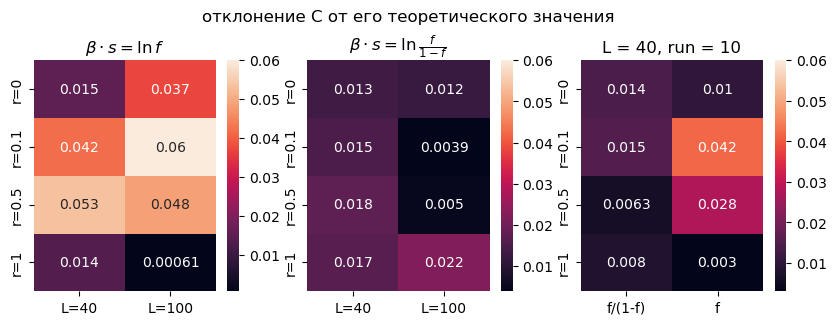

In [24]:
fig = plt.figure(figsize=(10,3))
ax = plt.subplot(131)
sns.heatmap(erC2.T, annot= True,vmax=0.06)
ax.set_title('$\\beta \\cdot s = \\ln{f}$')
ax = plt.subplot(132)
sns.heatmap(erC3.T, annot= True,vmax=0.06)
ax.set_title('$\\beta \\cdot s = \\ln{\\frac{f}{1-f}}$, run=100')
ax = plt.subplot(133)
sns.heatmap(erC10.T, annot= True,vmax=0.06)
ax.set_title('L = 40, run = 10')
fig.suptitle('отклонение С от его теоретического значения',y=1.05);

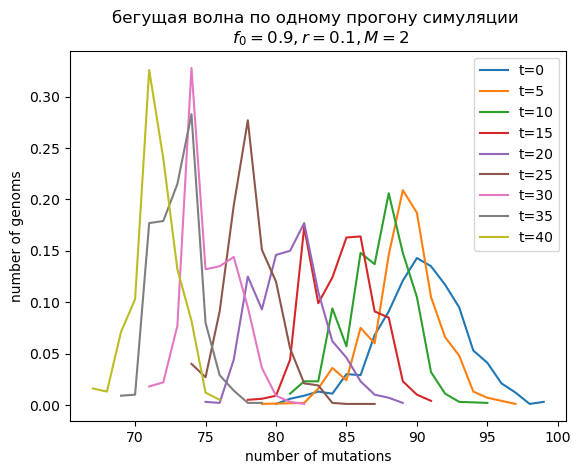

In [25]:
for i in range(9):
    m = gr_3s10205run100.miDicts[85][f'm{i+1}'].df.copy()
    m.loc[:,'msum'] = m.T.sum()
    
    x = m.msum.value_counts(normalize=True).sort_index(ascending=True).index
    y = m.msum.value_counts(normalize=True).sort_index(ascending=True).values
    plt.plot(x,y,label=f't={gr_3s10205run100.tsecs[i]}')
plt.legend()
plt.xlabel('number of mutations')
plt.ylabel('number of genoms')
plt.title(f'бегущая волна по одному прогону симуляции \n $f_0=0.9, r=0.1, M=2 $');

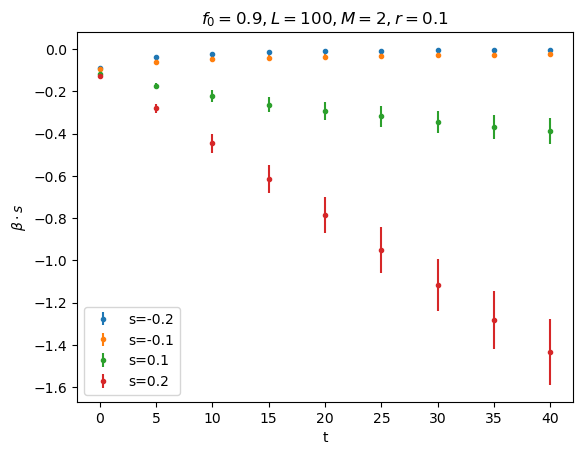

In [26]:
bs, std_bs, bs1_f, std_bs1_f=bst(gr_3s10205run100,0.9,M=2,r=0.1, f1_f=False)

In [27]:
gr_3s10205run100.real_s

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
s,-0.2,-0.1,0.1,0.2,-0.2,-0.1,0.1,0.2,-0.2,-0.1,...,0.1,0.2,-0.2,-0.1,0.1,0.2,-0.2,-0.1,0.1,0.2


In [35]:
def errorCounter(gr,p,f0=0.9):
    L = len(gr.FrameN)

    ln = ([np.log((gr.FrameN.loc[i,p]*(1-f0))/
                         ((1-gr.FrameN.loc[i,p])*f0))
                         for i in range(1,L+1)])
    lnsum = sum([np.log((gr.FrameN.loc[i,p]*(1-f0))/
                         ((1-gr.FrameN.loc[i,p])*f0))
                         for i in range(1,L+1)])
    si = ([gr.real_s[i]['s']
                         for i in range(1,L+1)])
    ssum = sum([gr.real_s[i]['s']
                         for i in range(1,L+1)])
    beta = -lnsum/ssum
    #тут взял среднее бета вместо суммы, а то иначе странная пила получается
    #хотя я не уверен что это как-то обосновано
    er = [abs(((beta)*gr.real_s[i]['s']+
           np.log((gr.FrameN.loc[i,p]*(1-f0))/
                  ((1-gr.FrameN.loc[i,p])*f0))))
          for i in range(1,L+1)]
    er_ = [abs((ln[i]+beta*si[i]))/((-ln[i]+beta*si[i])/2) for i in range(L)]
    return er_

In [59]:
er_ = errorCounter(gr10401,9)

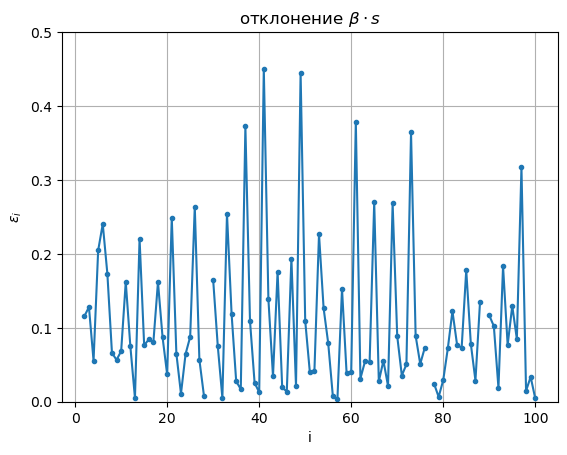

In [61]:
L=100
df = pd.DataFrame(er_,range(1,L+1))
df = df[df < 0.5 ]
plt.plot(df,'.-');
plt.xlabel('i')
plt.ylabel('$\\epsilon_i$')
plt.title('отклонение $\\beta \\cdot s$')
plt.ylim(0,0.5)
plt.grid()

In [42]:
# plt.plot(range(1,L+1),er_)
# plt.xlabel('i')
# plt.ylabel('$\\epsilon_i$')
# plt.grid()
# plt.ylim(0,0.5)

In [30]:
gr_2s4201.C

NameError: name 'gr_2s4201' is not defined

In [73]:
abs((np.log(0.9)+gr_2s4201.C))/abs(gr_2s4201.C)

0.041897074696211144

In [71]:
gr_3s4201.C

-2.1643410248754673

In [74]:
abs((np.log(0.9/(1-0.9))+gr_3s4201.C))/abs(gr_3s4201.C)

0.01519333232739712

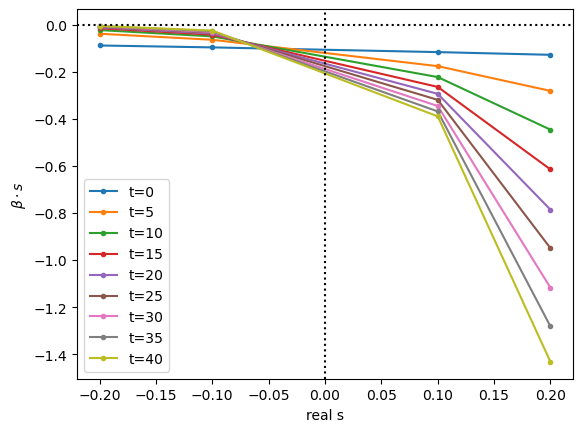

In [128]:
ss=[-0.2,-0.1,0.1,0.2]
for t in range(1,10):
    plt.plot(ss,bs.loc[t],'.-',label=f't={gr_3s10205run100.tsecs[t-1]}')
plt.xlabel('real s')
plt.ylabel('$\\beta \\cdot s$')
plt.legend()
axes = plt.gca()
axes.axhline(y=0, color='k',ls=':')  
axes.axvline(x=0, color='k',ls=':')

In [ ]:
bs

In [ ]:
t=np.array(gr1021.tsecs,dtype='int')
N=1000
Ub=0.25/(N*0.2**2)
# s_av=(0.05+0.1+0.15+0.2)/4
s_av=0.2
t0=1/s_av
mu=Ub/100
fi0=np.log(s_av/Ub)/(2*np.sqrt(np.pi)*N*s_av)
beta=mu*N*fi0*(t-t0)
beta

In [ ]:
plt.figure(dpi=200,figsize=(5,3))
plt.plot(t,beta,'.-')
plt.grid()
plt.xlabel('t')
plt.ylabel('$ \\beta (t) $');
plt.title("$\\beta = \\mu \\cdot N \\cdot \\phi_0' \\cdot (t-t_0)$");

In [36]:
gr10201.C

-1.9583421648401538

In [25]:
np.log(0.9/(1-0.9))

2.1972245773362196

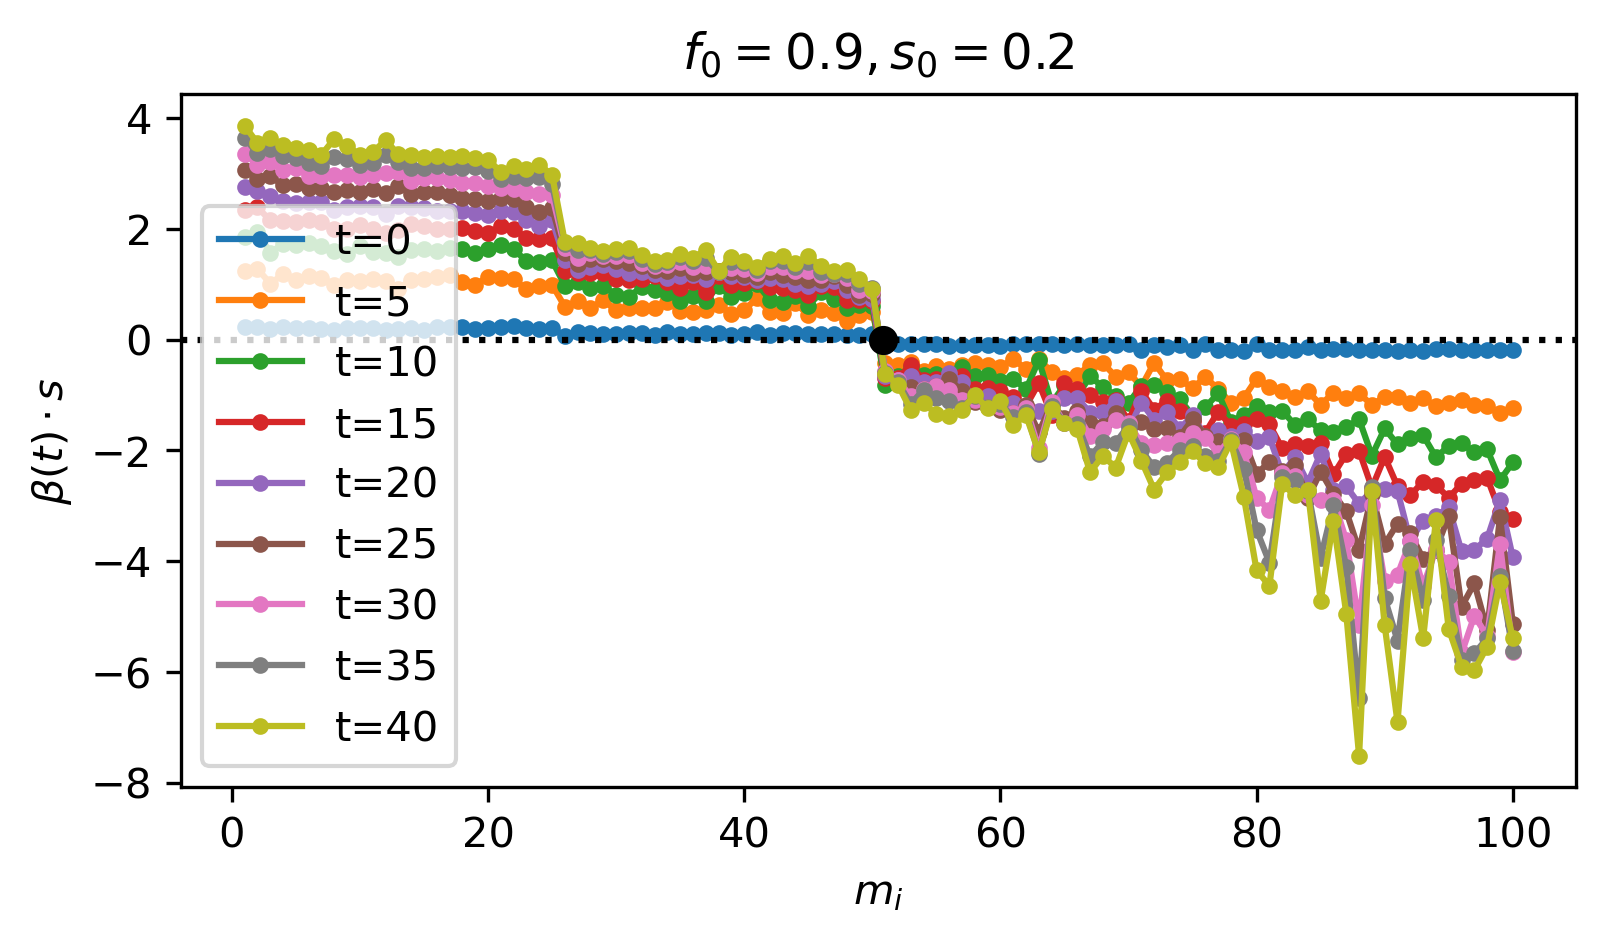

In [129]:
gr_3s10205run100.sMeasureLine()

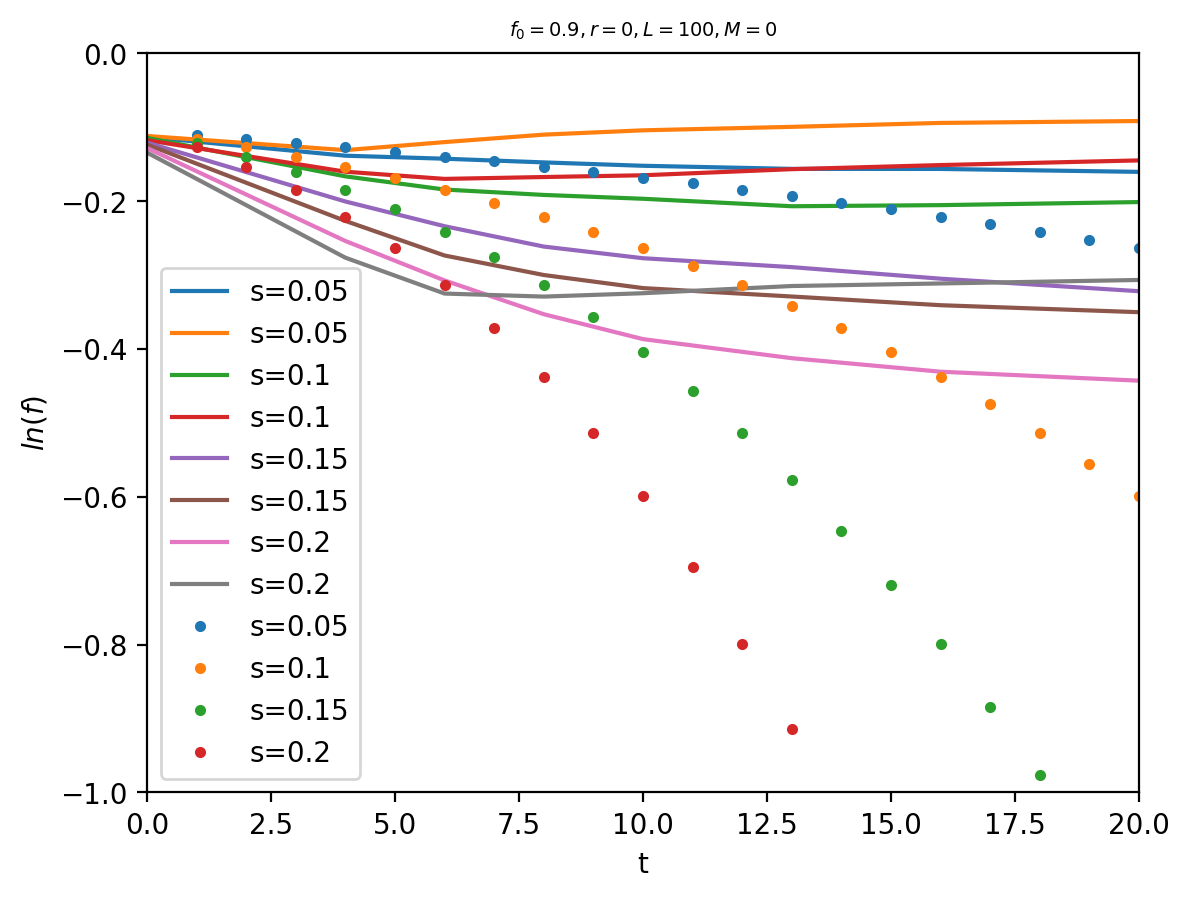

In [25]:
# ln_t(grf421,5,1,L=40,M=1/2,tlines=True);
# ln_t(grf4201,5,1,L=40,M=1/2,tlines=True);
# ln_t(grf420,5,1,L=40,M=1/2,tlines=True);
ln_t(gr1040,13,0,L=100,M=0, tlines=True);
# ln_t(gr4201,5,0.1,L=40,M=1/2,tlines=True);
# ln_t(gr10201,15,0.1,L=100,M=1/2,tlines=True);
# # ln_t(gr4401,5,0.1,L=40,M=1/4);
# ln_t(gr10401,13,0.1,L=100,M=1/4);
# # ln_t(gr4205,5,0.5,L=40,M=1/2);
# # ln_t(gr10205,15,0.5,L=100,M=1/2);
# # ln_t(gr4405,5,0.5,L=40,M=1/4);
# ln_t(gr10405,15,0.5,L=100,M=1/4);
# f=ln_t(gr421,1,1,L=40,M=1/2,tlines=True,f_1f_fig=True);
# f=ln_t(gr1021,15,1,L=100,M=1/2,tlines=True,f_1f_fig=True);
# ln_t(gr441,5,1,L=40,M=1/4,tlines=True);
# ln_t(gr1041,13,1,L=100,M=1/4,tlines=True); +++
# ln_t(gr2040,25,0,L=200,M=1/4);
# ln_t(gr20401,25,0.1,L=200,M=1/4);

# ln_t(gr2041,25,1,L=200,M=1/4,tlines=True);
plt.ylim(-1,0)
plt.xlim(0,20);

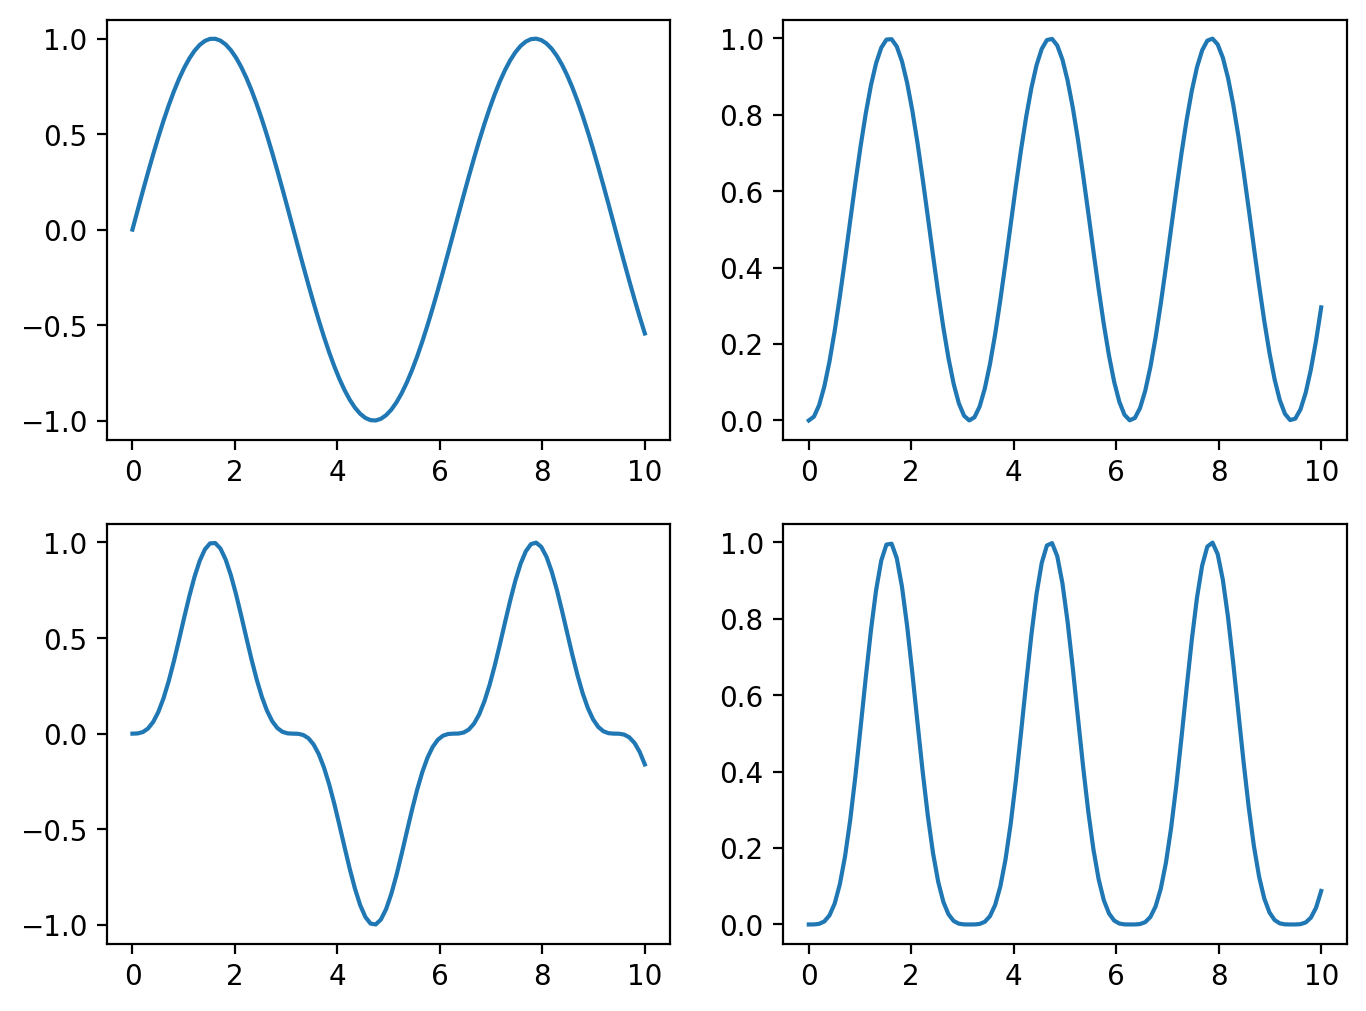

In [16]:
'''
эксперименты с плотами
'''
x = np.linspace(0,10,100)
y = np.sin(x)
plt.figure(dpi=200,figsize=(8,6))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(x,y**(i+1))